## Predicting User Interactions Using Machine Learning

The dataset is downloaded from https://www.kaggle.com/datasets/mkechinov/ecommerce-behavior-data-from-multi-category-store.
2019-Oct (5.5 GB) is used only.

In [ ]:
#%reset

In [ ]:
# Mount the google drive
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!pip install squarify
!pip install catboost

In [ ]:
# Data Manipulation and Analysis
import numpy as np
import pandas as pd
from datetime import datetime

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import squarify

# Machine Learning Models and Utilities
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import IsolationForest, RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier, plot_importance
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Metrics and Evaluation
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    roc_curve,
    auc,
    confusion_matrix,
    brier_score_loss,
    matthews_corrcoef
)

# Feature Engineering and Selection
from sklearn.feature_selection import RFE

# Oversampling and Undersampling for Imbalanced Data
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Statistical Analysis
from scipy.stats import chi2_contingency, ttest_ind, f_oneway

# Deep Learning
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Model Explainability
import shap

# Utilities
from tqdm import tqdm

In [ ]:
#plt.rcParams['figure.figsize'] = (7, 5)

#plt.rcParams['font.sans-serif'] = "Trebuchet MS"

# Then, "ALWAYS use sans-serif fonts"
#plt.rcParams['font.family'] = "sans-serif"

Since the dataset is skewed (very high number of records with view events, the dataset is balanced by sampling number of *view* events equal to the *purchase* and *cart* combined.

In [ ]:
df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Shubham-Github/training_data.csv")

In [ ]:
df.head()

,Unnamed: 0,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,category,subcategory,is_purchased,event_weekday,sub-category,activity_count
0,0,2019-10-01 00:09:33 UTC,cart,1002524,2053013555631882655,electronics.smartphone,apple,515.67,524325294,0b74a829-f9d7-4654-b5b0-35bc9822c238,electronics,smartphone,1,1,smartphone,2
1,1,2019-10-01 00:11:00 UTC,cart,4804056,2053013554658804075,electronics.audio.headphone,apple,161.98,533624186,e5ac3caa-e6d5-4d6b-ae06-2c18cd9ca683,electronics,audio,0,1,audio,2
2,2,2019-10-01 02:17:59 UTC,cart,1004833,2053013555631882655,electronics.smartphone,samsung,174.76,536415846,685b5b42-f597-4a69-ab4c-ef96a30bc454,electronics,smartphone,0,1,smartphone,3
3,3,2019-10-01 02:19:36 UTC,cart,1005003,2053013555631882655,electronics.smartphone,huawei,258.21,513632293,f2cc68f7-39d1-4a50-9dcf-f2a0921bdfda,electronics,smartphone,1,1,smartphone,5
4,4,2019-10-01 02:19:43 UTC,cart,1004750,2053013555631882655,electronics.smartphone,samsung,197.43,555110488,ce885079-4d92-4fe6-92a3-377c5a2d8291,electronics,smartphone,1,1,smartphone,6


In [ ]:
def balance_dataset_with_smote(PATH):
    # Load the dataset
    df = pd.read_csv(PATH)

    # Filter the data to include only relevant events
    df_targets = df[df['event_type'].isin(['cart', 'purchase'])]

    if df_targets['event_type'].nunique() < 2:
        print("The dataset is missing one of the required event types: 'cart' or 'purchase'.")

        # Simulate missing class if needed
        if 'purchase' not in df_targets['event_type'].unique():
            simulated_purchase = df_targets[df_targets['event_type'] == 'cart'].copy()
            simulated_purchase['event_type'] = 'purchase'
            df_targets = pd.concat([df_targets, simulated_purchase])
            print(f"Simulated {len(simulated_purchase)} 'purchase' events.")

    # Prepare features and target for SMOTE
    df_targets['is_purchased'] = np.where(df_targets['event_type'] == 'purchase', 1, 0)

    # Retain original mappings for decoding later
    original_category_codes = df_targets['category_code'].dropna().unique()
    category_label_encoder = LabelEncoder()
    category_label_encoder.fit(original_category_codes)

    event_label_encoder = LabelEncoder()
    event_label_encoder.fit(df_targets['event_type'].unique())

    # Encode categorical features
    features = df_targets[['price', 'brand', 'category_code', 'user_session', 'event_type']].copy()
    target = df_targets['is_purchased']

    for col in ['brand', 'category_code', 'user_session', 'event_type']:
        features[col] = LabelEncoder().fit_transform(features[col].astype(str))

    # Apply SMOTE to balance the dataset
    smote = SMOTE(random_state=42)
    balanced_features, balanced_target = smote.fit_resample(features, target)

    # Convert back to DataFrame for ease of use
    balanced_df = pd.DataFrame(balanced_features, columns=['price', 'brand', 'category_code', 'user_session', 'event_type'])
    balanced_df['is_purchased'] = balanced_target

    # Decode `event_type` and `category_code` back to their original values
    balanced_df['event_type'] = event_label_encoder.inverse_transform(balanced_df['event_type'].astype(int))
    balanced_df['category_code'] = category_label_encoder.inverse_transform(balanced_df['category_code'].astype(int))

    # Debugging: Check the final class distribution
    print("Class distribution after SMOTE:")
    print(balanced_df['is_purchased'].value_counts())
    print("\nEvent type distribution after SMOTE:")
    print(balanced_df['event_type'].value_counts())
    print("\nTop 10 categories by count:")
    print(balanced_df['category_code'].value_counts().head(10))

    return balanced_df

# Call the function and check the result
balanced_df = balance_dataset_with_smote("/content/drive/My Drive/Colab Notebooks/Shubham-Github/training_data.csv")

# Additional debugging outputs
print("Class distribution in 'is_purchased':")
print(balanced_df['is_purchased'].value_counts())

print("\nTop 10 categories by `category_code` count:")
print(balanced_df['category_code'].value_counts().head(10))

print("\nEvent type distribution in 'event_type':")
print(balanced_df['event_type'].value_counts())

The dataset is missing one of the required event types: 'cart' or 'purchase'.
Simulated 546600 'purchase' events.
Class distribution after SMOTE:
is_purchased
0    546600
1    546600
Name: count, dtype: int64

Event type distribution after SMOTE:
event_type
cart        546600
purchase    546600
Name: count, dtype: int64

Top 10 categories by count:
category_code
electronics.smartphone              734868
electronics.audio.headphone          68258
electronics.video.tv                 49346
appliances.kitchen.washer            29214
electronics.clocks                   28670
appliances.environment.vacuum        23486
computers.notebook                   22334
appliances.kitchen.refrigerators     16866
electronics.tablet                   12234
electronics.telephone                 7412
Name: count, dtype: int64
Class distribution in 'is_purchased':
is_purchased
0    546600
1    546600
Name: count, dtype: int64

Top 10 categories by `category_code` count:
category_code
electronics.smartph

In [ ]:
print(balanced_df.columns)

Index(['price', 'brand', 'category_code', 'user_session', 'event_type',
       'is_purchased'],
      dtype='object')


In [ ]:
balanced_df

,price,brand,category_code,user_session,event_type,is_purchased
0,515.67,21,electronics.smartphone,22421,cart,0
1,161.98,21,electronics.audio.headphone,447666,cart,0
2,174.76,292,electronics.smartphone,203471,cart,0
3,258.21,159,electronics.smartphone,473186,cart,0
4,197.43,292,electronics.smartphone,402702,cart,0
...,...,...,...,...,...,...
1093195,242.63,292,electronics.smartphone,291601,purchase,1
1093196,275.25,292,electronics.smartphone,99026,purchase,1
1093197,1889.07,21,electronics.smartphone,62900,purchase,1
1093198,577.89,21,electronics.smartphone,474259,purchase,1


In [ ]:
balanced_df['event_type'].value_counts()

,count
event_type,
cart,546600
purchase,546600


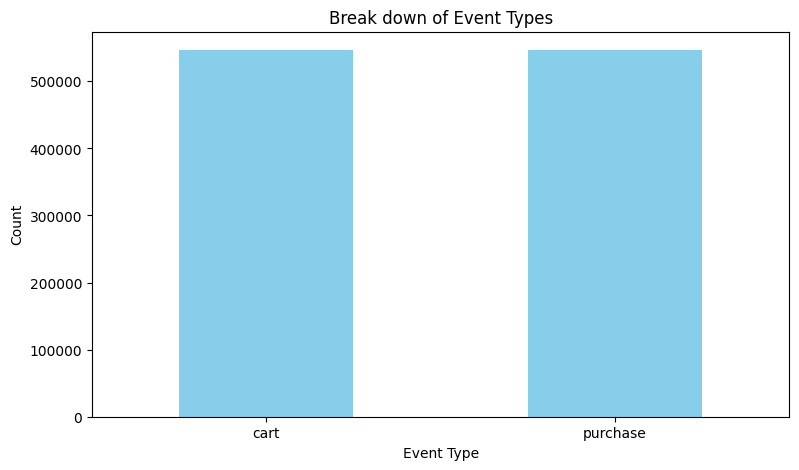

In [ ]:
counts = pd.Series(balanced_df['event_type']).value_counts()

# Plot the count for event types
plt.figure(figsize = (9, 5), dpi = 100)
counts.plot(kind='bar', color='skyblue')
plt.title('Break down of Event Types')
plt.xlabel('Event Type')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [ ]:
# Display the first few rows of the dataset
balanced_df.head()

,price,brand,category_code,user_session,event_type,is_purchased
0,515.67,21,electronics.smartphone,22421,cart,0
1,161.98,21,electronics.audio.headphone,447666,cart,0
2,174.76,292,electronics.smartphone,203471,cart,0
3,258.21,159,electronics.smartphone,473186,cart,0
4,197.43,292,electronics.smartphone,402702,cart,0


### Data Pre-Processing

In [ ]:
# Check the shape of the dataset
balanced_df.shape

(1093200, 6)

In [ ]:
# Check for missing values
balanced_df.isnull().sum()

,0
price,0
brand,0
category_code,0
user_session,0
event_type,0
is_purchased,0


In [ ]:
# Display dataset statistics for numerical columns
balanced_df.describe()

,price,brand,user_session,is_purchased
count,1.093200e+06,1.093200e+06,1.093200e+06,1093200.0
mean,3.771703e+02,1.937678e+02,2.493451e+05,0.5
std,3.687308e+02,1.289361e+02,1.440111e+05,0.5
min,1.000000e+00,0.000000e+00,0.000000e+00,0.0
25%,1.396600e+02,2.100000e+01,1.246048e+05,0.0
50%,2.406050e+02,2.690000e+02,2.492885e+05,0.5
75%,4.625600e+02,2.920000e+02,3.740612e+05,1.0
max,2.574040e+03,3.680000e+02,4.988430e+05,1.0


In [ ]:
def clean_data(df):
    df = df.dropna(subset=['price', 'category_code'])
    df = df[df['price'] >= 0]
    df['category_code'] = df['category_code'].astype(str)
    df = df[df['category_code'].str.strip().astype(bool)]
    return df

balanced_df = clean_data(balanced_df)

In [ ]:
balanced_df

,price,brand,category_code,user_session,event_type,is_purchased
0,515.67,21,electronics.smartphone,22421,cart,0
1,161.98,21,electronics.audio.headphone,447666,cart,0
2,174.76,292,electronics.smartphone,203471,cart,0
3,258.21,159,electronics.smartphone,473186,cart,0
4,197.43,292,electronics.smartphone,402702,cart,0
...,...,...,...,...,...,...
1093195,242.63,292,electronics.smartphone,291601,purchase,1
1093196,275.25,292,electronics.smartphone,99026,purchase,1
1093197,1889.07,21,electronics.smartphone,62900,purchase,1
1093198,577.89,21,electronics.smartphone,474259,purchase,1


### Exploratory Data Analysis

#### *How many customers visit the site?*

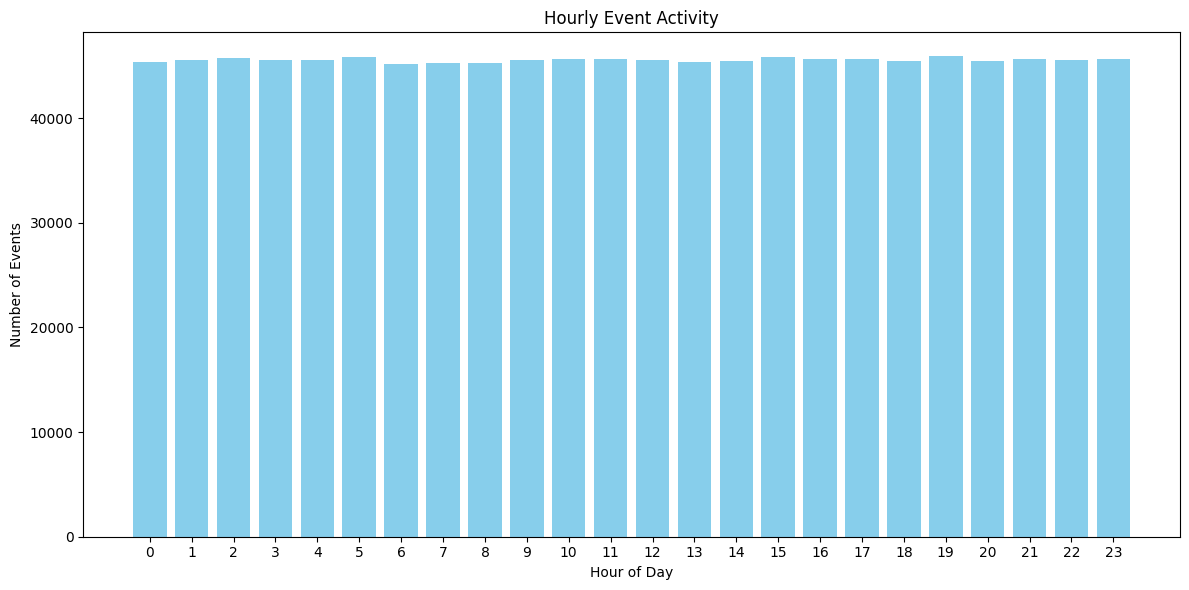

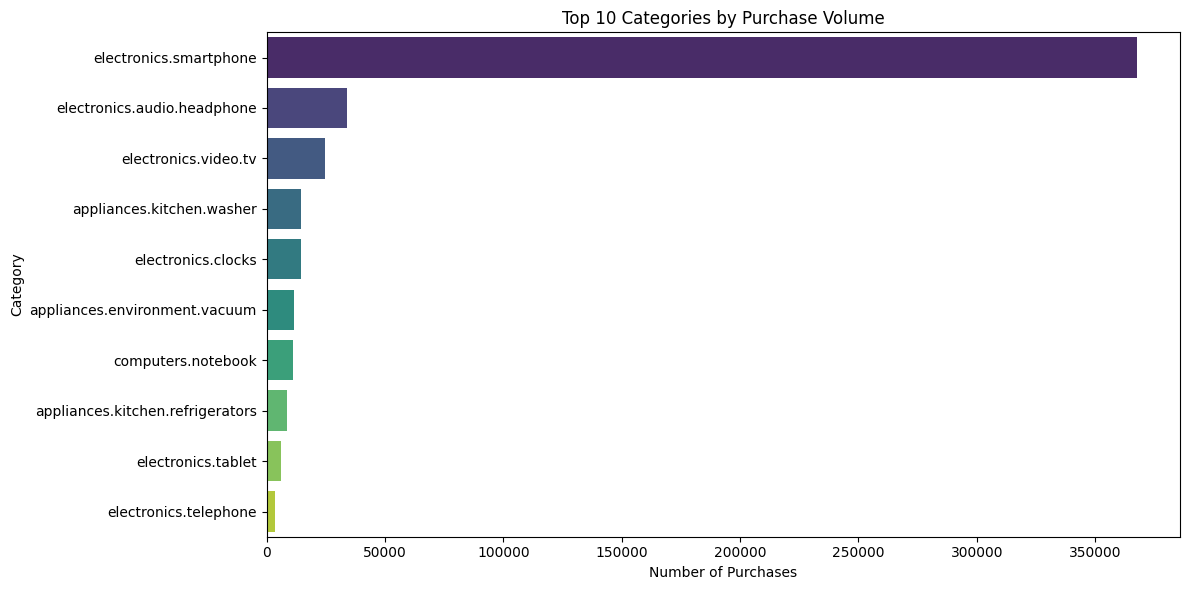

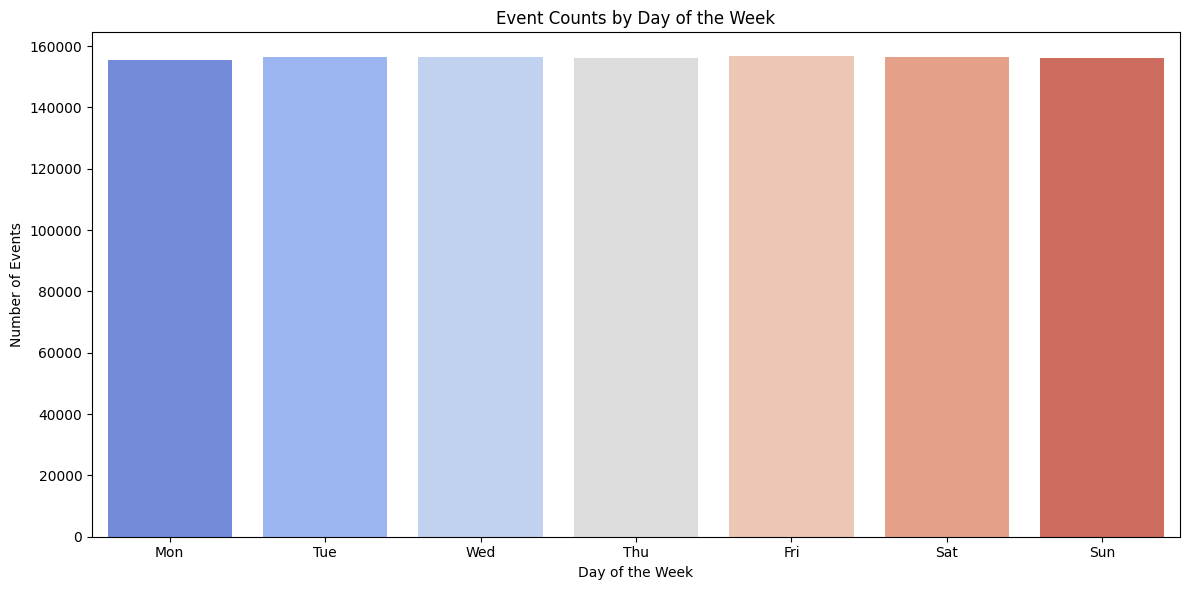

In [ ]:
def deep_eda_analysis(df):
    # Hourly activity (if `hour_of_day` exists or needs simulation)
    if 'hour_of_day' in df.columns:
        hourly_activity = df.groupby('hour_of_day')['event_type'].count()
    else:
        df['hour_of_day'] = np.random.randint(0, 24, size=len(df))
        hourly_activity = df.groupby('hour_of_day')['event_type'].count()

    plt.figure(figsize=(12, 6), dpi=100)
    plt.bar(hourly_activity.index, hourly_activity.values, color='skyblue')
    plt.title('Hourly Event Activity')
    plt.xlabel('Hour of Day')
    plt.ylabel('Number of Events')
    plt.xticks(range(0, 24))
    plt.tight_layout()
    plt.show()

    # Category-wise purchase trends (adjusted for available columns)
    if 'category_code' in df.columns:
        purchase_df = df[df['event_type'] == 'purchase']
        category_purchases = purchase_df['category_code'].value_counts().head(10)
        plt.figure(figsize=(12, 6), dpi=100)
        sns.barplot(x=category_purchases.values, y=category_purchases.index, palette='viridis')
        plt.title('Top 10 Categories by Purchase Volume')
        plt.xlabel('Number of Purchases')
        plt.ylabel('Category')
        plt.tight_layout()
        plt.show()

    # Weekly trend (if weekday simulation needed)
    if 'weekday' not in df.columns:
        df['weekday'] = np.random.randint(0, 7, size=len(df))  # Simulate weekday data
    weekday_visits = df.groupby('weekday')['event_type'].count()
    plt.figure(figsize=(12, 6), dpi=100)
    sns.barplot(x=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], y=weekday_visits.values, palette='coolwarm')
    plt.title('Event Counts by Day of the Week')
    plt.xlabel('Day of the Week')
    plt.ylabel('Number of Events')
    plt.tight_layout()
    plt.show()

# Call the modified function
deep_eda_analysis(balanced_df)

Number of anomalies detected: 10758


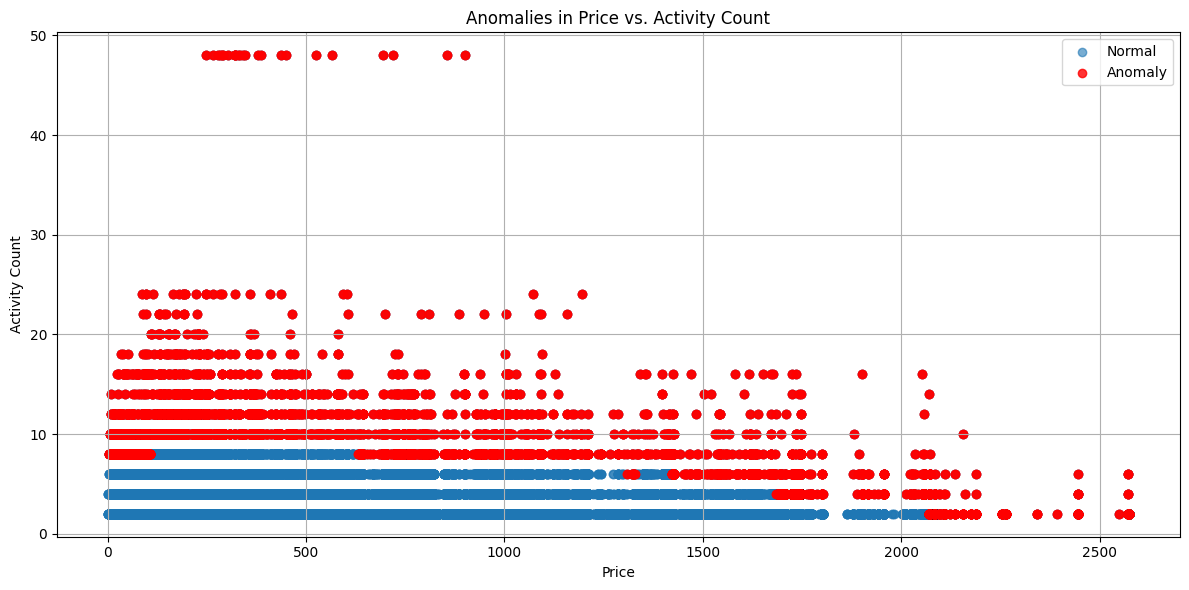

In [ ]:
def anomaly_detection(df):
    # Ensure 'activity_count' is present in the DataFrame
    if 'activity_count' not in df.columns:
        # Create 'activity_count' by counting the number of events per session
        activity_in_session = df.groupby('user_session')['event_type'].count().reset_index()
        activity_in_session = activity_in_session.rename(columns={"event_type": "activity_count"})
        df = df.merge(activity_in_session, on='user_session', how='left')

    # Keep only numerical features and drop rows with missing values
    df = df[['price', 'activity_count']].dropna()

    # Fit Isolation Forest for anomaly detection
    iso_forest = IsolationForest(contamination=0.01, random_state=42)
    df['anomaly_score'] = iso_forest.fit_predict(df[['price', 'activity_count']])

    # Extract anomalies
    anomalies = df[df['anomaly_score'] == -1]
    print(f"Number of anomalies detected: {len(anomalies)}")

    # Visualize anomalies
    plt.figure(figsize=(12, 6), dpi=100)
    plt.scatter(df['price'], df['activity_count'], label='Normal', alpha=0.6)
    plt.scatter(anomalies['price'], anomalies['activity_count'], color='red', label='Anomaly', alpha=0.8)
    plt.title('Anomalies in Price vs. Activity Count')
    plt.xlabel('Price')
    plt.ylabel('Activity Count')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return anomalies

# Call the updated function
anomalies = anomaly_detection(balanced_df)

In [ ]:
balanced_df

,price,brand,category_code,user_session,event_type,is_purchased,hour_of_day,weekday
0,515.67,21,electronics.smartphone,22421,cart,0,19,1
1,161.98,21,electronics.audio.headphone,447666,cart,0,3,0
2,174.76,292,electronics.smartphone,203471,cart,0,14,2
3,258.21,159,electronics.smartphone,473186,cart,0,11,4
4,197.43,292,electronics.smartphone,402702,cart,0,4,3
...,...,...,...,...,...,...,...,...
1093195,242.63,292,electronics.smartphone,291601,purchase,1,13,3
1093196,275.25,292,electronics.smartphone,99026,purchase,1,14,0
1093197,1889.07,21,electronics.smartphone,62900,purchase,1,9,6
1093198,577.89,21,electronics.smartphone,474259,purchase,1,14,1


#### *Which category customers interact with the most?*

#### *What items do visitors purchase?*

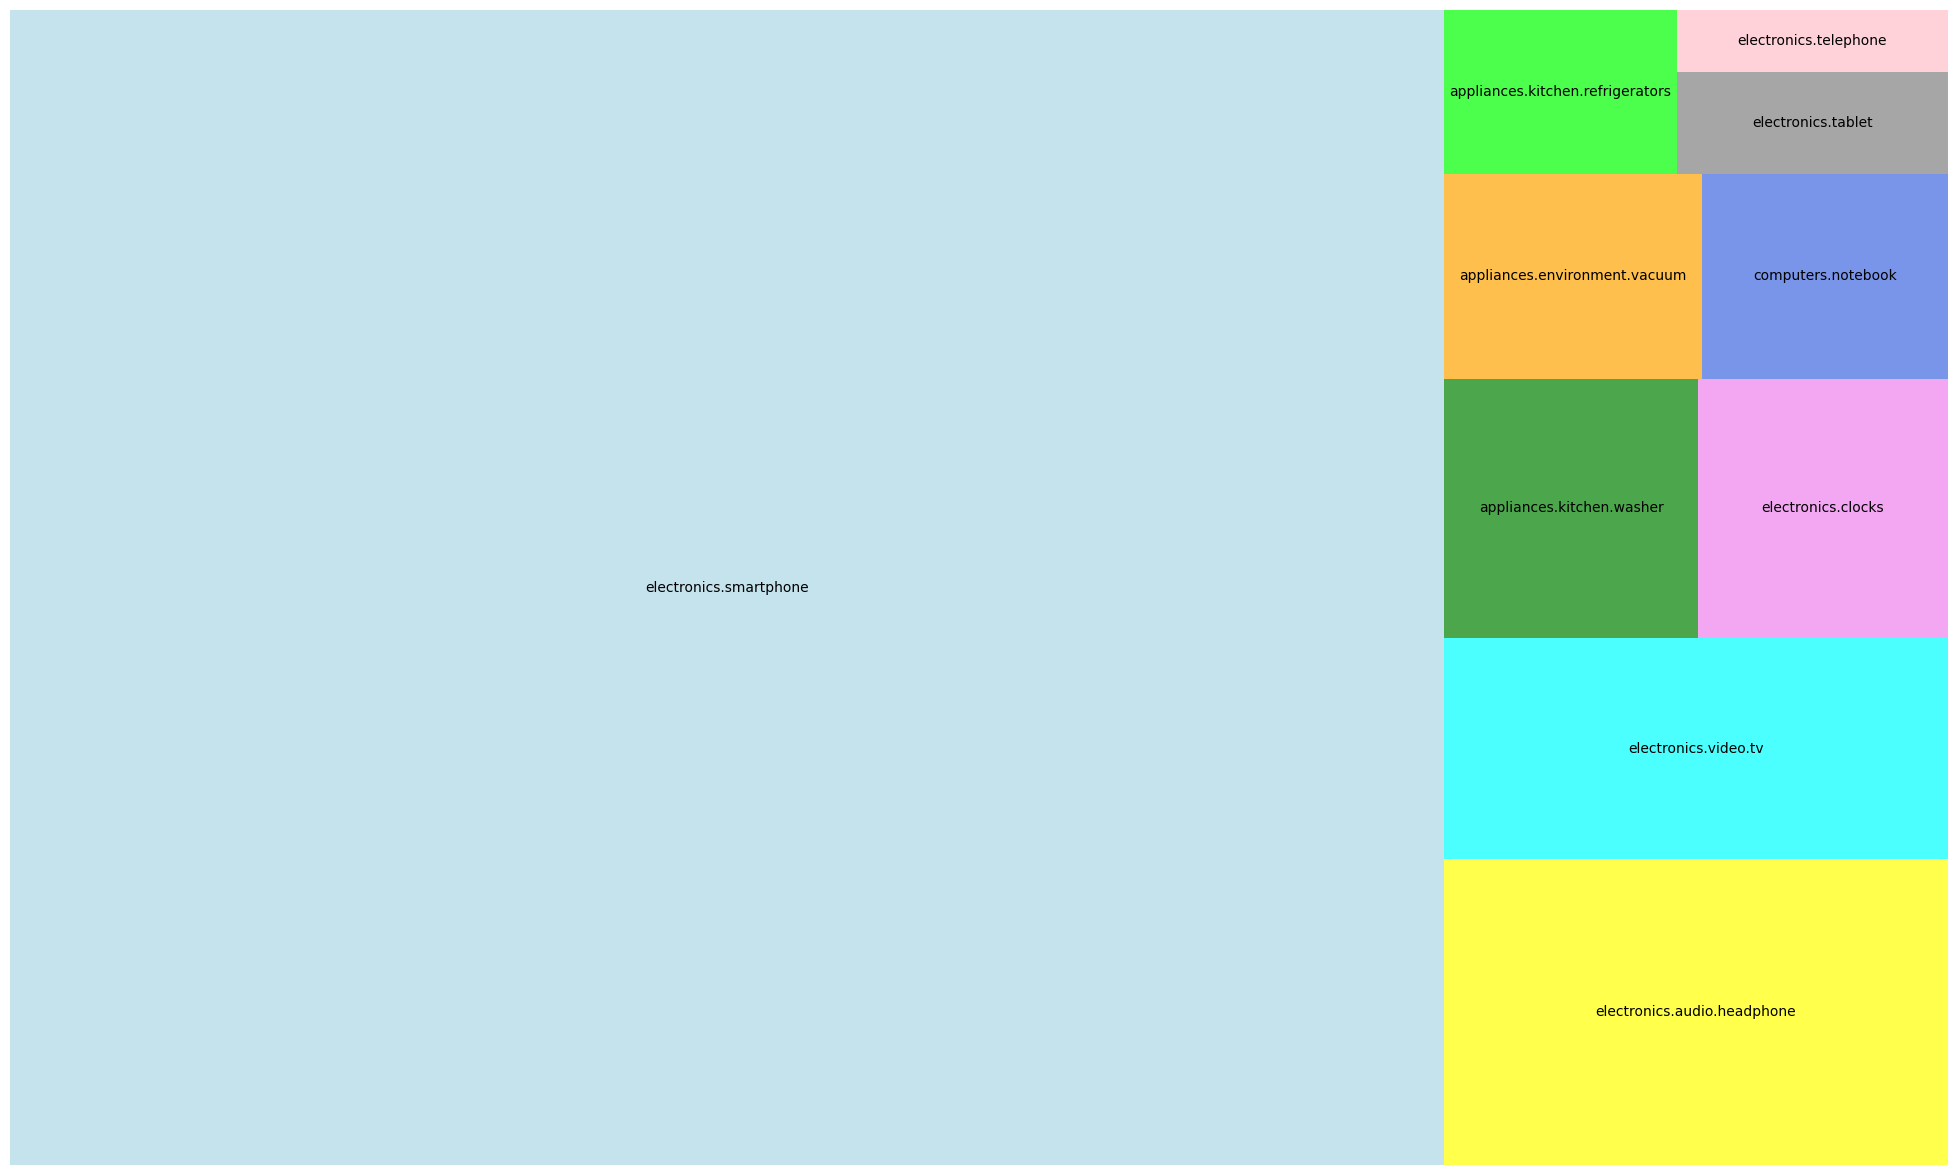

In [ ]:
top_category_n = 10
plt.figure(figsize = (25, 15), dpi = 100)
top_category = balanced_df.loc[:,'category_code'].value_counts()[:top_category_n].sort_values(ascending=False)
squarify.plot(sizes=top_category, label=top_category.index.array,
              color=["lightblue", "yellow","cyan","green", "violet", "orange","royalblue", "lime","grey", "pink"], alpha=.7  )
plt.axis('off')
plt.show()

In [ ]:
purchase = balanced_df.loc[balanced_df['event_type'] == 'purchase']
purchase.head()

,price,brand,category_code,user_session,event_type,is_purchased,hour_of_day,weekday
546600,515.67,21,electronics.smartphone,22421,purchase,1,8,0
546601,161.98,21,electronics.audio.headphone,447666,purchase,1,16,3
546602,174.76,292,electronics.smartphone,203471,purchase,1,8,2
546603,258.21,159,electronics.smartphone,473186,purchase,1,10,6
546604,197.43,292,electronics.smartphone,402702,purchase,1,23,0


#### *Which categories are users most interested in?*

In [ ]:
#user defined functions
def extract_categorycode(input_text,level=0):
    '''
     this function splits category code and returns the first part.
    '''
    output_text=input_text.split('.')[level]
    return output_text

In [ ]:
#splitting the category text into 2 pieces as category and subcategory
balanced_df['category']=balanced_df['category_code'].apply(extract_categorycode,level=0)
balanced_df['subcategory']=balanced_df['category_code'].apply(extract_categorycode,level=1)

In [ ]:
# Creating a summary table for categories and activities
category_summary_table = balanced_df.groupby(by=['category_code']).agg(
    number_of_views=('category_code', 'count'),
    number_of_sessions=('user_session', pd.Series.nunique)
).reset_index()

# Filtering purchases
sales_filter = balanced_df['event_type'] == 'purchase'
category_sales_summary_table = balanced_df.loc[sales_filter].groupby(by=['category_code']).agg(
    number_of_purchase=('category_code', 'count'),
    amount_of_purchase=('price', 'sum'),
    average_purchase_amount=('price', 'mean'),
    number_of_sessions_with_purchase=('user_session', pd.Series.nunique)
).reset_index()

# Merging both tables
category_summary_table = pd.merge(
    left=category_summary_table,
    right=category_sales_summary_table,
    on='category_code',
    how='left'
)

# Adding conversion rate column
category_summary_table['conversion_rate'] = (
    category_summary_table['number_of_purchase'] / category_summary_table['number_of_sessions']
)

# Display the resulting summary table
print(category_summary_table.head())

                            category_code  number_of_views  \
0                         accessories.bag              778   
1                    accessories.umbrella               10   
2                            apparel.sock                6   
3                          apparel.tshirt               28   
4  appliances.environment.air_conditioner              474   

   number_of_sessions  number_of_purchase  amount_of_purchase  \
0                 374                 389            17178.29   
1                   5                   5              128.55   
2                   3                   3              509.58   
3                  13                  14              211.50   
4                 231                 237            70830.90   

   average_purchase_amount  number_of_sessions_with_purchase  conversion_rate  
0                44.160129                               374         1.040107  
1                25.710000                                 5         1.00000

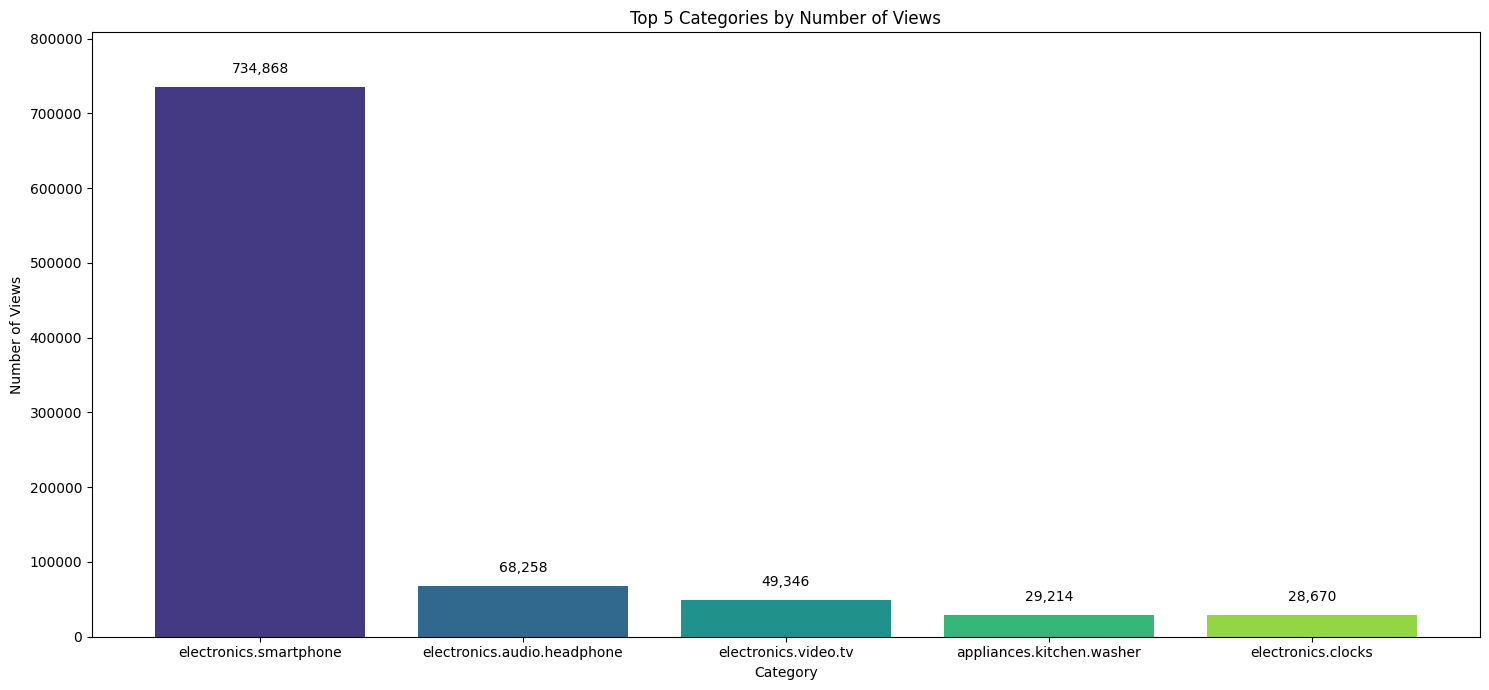

In [ ]:
# Select the top 5 categories based on 'number_of_views'
top_5_categories = category_summary_table.nlargest(5, 'number_of_views')

plt.figure(figsize=(15, 7), dpi=100)

# Use seaborn's viridis palette for colors
colors = sns.color_palette('viridis', len(top_5_categories))

# Plot the bar chart for top 5 categories
bars = plt.bar(top_5_categories['category_code'], top_5_categories['number_of_views'], color=colors)

# Annotate the bars with the number of views
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2,
             bar.get_height() + (0.02 * top_5_categories['number_of_views'].max()),
             format(bar.get_height(), ',.0f'),
             ha='center', va='bottom')

plt.title('Top 5 Categories by Number of Views')
plt.xlabel('Category')
plt.ylabel('Number of Views')
plt.ylim(0, top_5_categories['number_of_views'].max() * 1.1)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

#### *What brands do the visitors buy?*

In [ ]:
top_sellers = purchase.groupby('brand')['brand'].agg(['count']).sort_values('count', ascending=False)
top_sellers.head(20)

,count
brand,
292,198185
21,146487
359,53147
159,27525
251,13470
202,8429
0,6719
110,5451
168,4607


<Figure size 800x500 with 0 Axes>

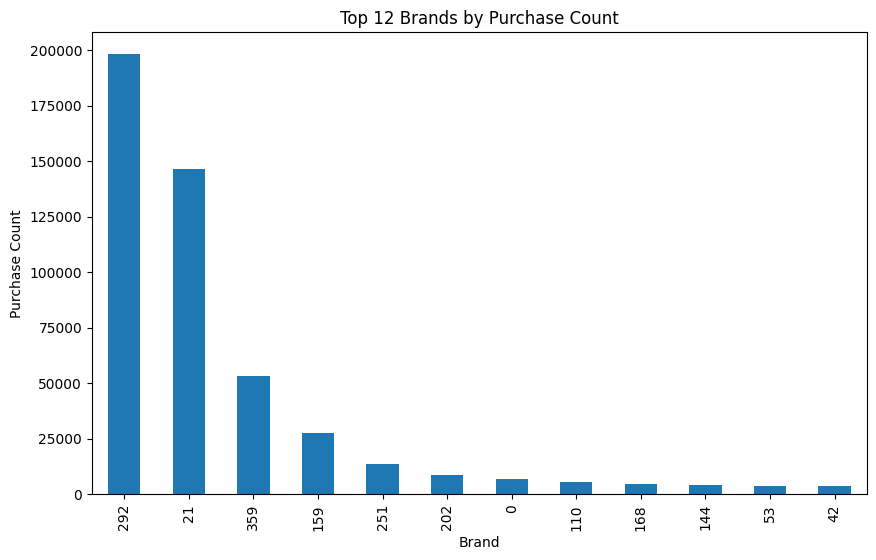

In [ ]:
plt.figure(figsize = (8, 5), dpi = 100)
top_12_sellers = top_sellers.head(12)
top_12_sellers.plot(kind='bar', legend=False, figsize=(10,6))
plt.title('Top 12 Brands by Purchase Count')
plt.ylabel('Purchase Count')
plt.xlabel('Brand')
plt.show()

#### *What is the price range of products?*

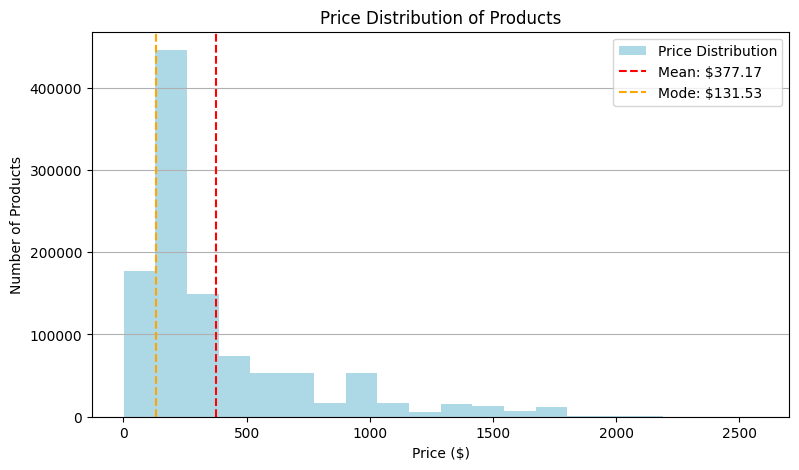

In [ ]:
# Plot the histogram of price
plt.figure(figsize=(9, 5), dpi=100)
plt.hist(balanced_df['price'], bins=20, color='lightblue', label='Price Distribution')

# Compute mean and mode
mean_price = np.mean(balanced_df['price'])
mode_price = balanced_df['price'].mode().iloc[0]

# Add dashed lines for mean and mode
plt.axvline(mean_price, color='r', linestyle='--', label=f'Mean: ${mean_price:.2f}')
plt.axvline(mode_price, color='orange', linestyle='--', label=f'Mode: ${mode_price:.2f}')

plt.title("Price Distribution of Products")
plt.xlabel("Price ($)")
plt.ylabel("Number of Products")
plt.grid(axis='y')
plt.legend()
plt.show()


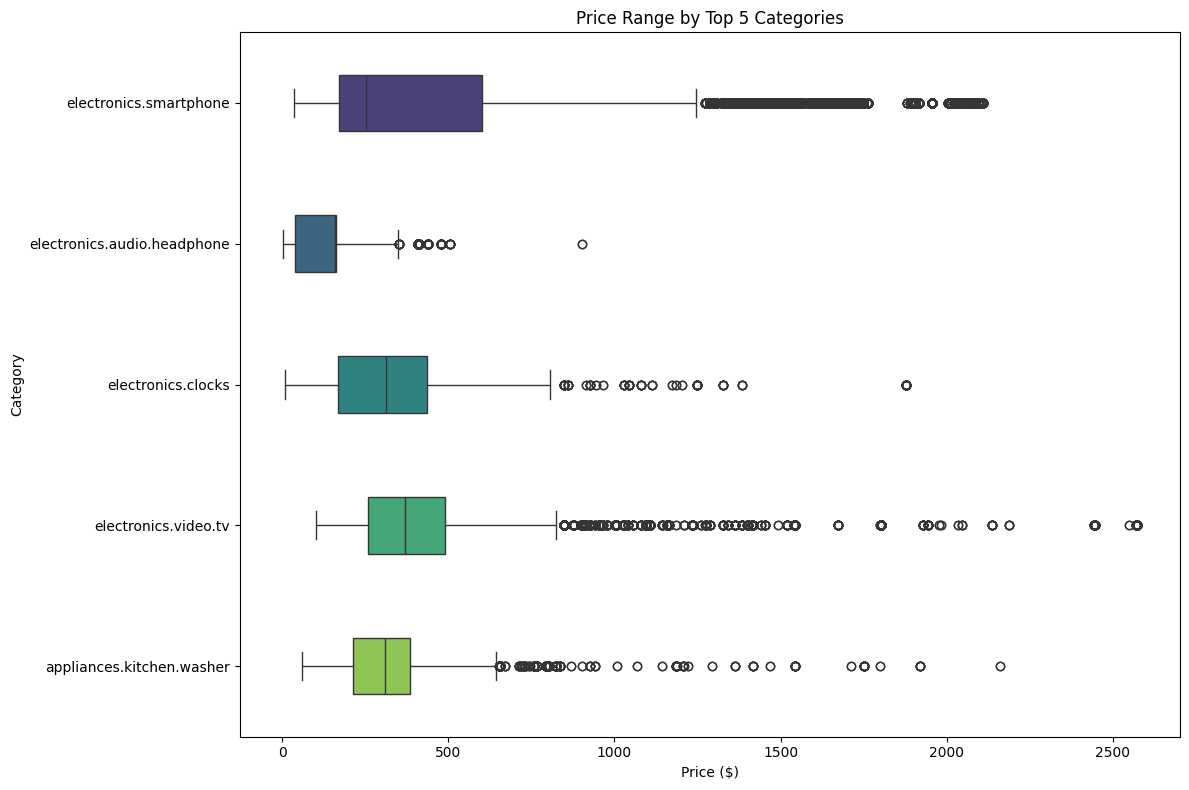

In [ ]:
# Select the top 5 categories by number of views or any metric
top_5_categories = balanced_df['category_code'].value_counts().head(5).index
top_5_data = balanced_df[balanced_df['category_code'].isin(top_5_categories)]

plt.figure(figsize=(12, 8), dpi=100)

# Use the viridis palette for the boxplot
sns.boxplot(data=top_5_data, y='category_code', x='price', width=0.4, palette="viridis")

plt.title('Price Range by Top 5 Categories')
plt.ylabel('Category')
plt.xlabel('Price ($)')
plt.tight_layout()
plt.show()

### Feature Engineering

Some new features are introduced into the training data set:

- category
- sub-category
- event_weekday: weekday of the event
- activity_count: number of events in that session
- is_purchased: whether the item added to the cart is purchased

Thus, the training data set contains every non-duplicated cart transaction. These features along with the original price and brand will be used to predict whether customers will eventually purchase the item in the cart.

In [ ]:
print(balanced_df.columns)

Index(['price', 'brand', 'category_code', 'user_session', 'event_type',
       'is_purchased', 'hour_of_day', 'weekday', 'category', 'subcategory'],
      dtype='object')


In [ ]:
balanced_df

,price,brand,category_code,user_session,event_type,is_purchased,hour_of_day,weekday,category,subcategory
0,515.67,21,electronics.smartphone,22421,cart,0,19,1,electronics,smartphone
1,161.98,21,electronics.audio.headphone,447666,cart,0,3,0,electronics,audio
2,174.76,292,electronics.smartphone,203471,cart,0,14,2,electronics,smartphone
3,258.21,159,electronics.smartphone,473186,cart,0,11,4,electronics,smartphone
4,197.43,292,electronics.smartphone,402702,cart,0,4,3,electronics,smartphone
...,...,...,...,...,...,...,...,...,...,...
1093195,242.63,292,electronics.smartphone,291601,purchase,1,13,3,electronics,smartphone
1093196,275.25,292,electronics.smartphone,99026,purchase,1,14,0,electronics,smartphone
1093197,1889.07,21,electronics.smartphone,62900,purchase,1,9,6,electronics,smartphone
1093198,577.89,21,electronics.smartphone,474259,purchase,1,14,1,electronics,smartphone


In [ ]:
def feature_engineering(balanced_df):
    # Step 1: Filter relevant event types
    df_targets = balanced_df[balanced_df["event_type"].isin(["cart", "purchase"])].copy()
    print("Filtered Dataframe Shape:", df_targets.shape)

    # Step 2: Add 'is_purchased' column
    df_targets["is_purchased"] = np.where(df_targets["event_type"] == "purchase", 1, 0)

    # Step 3: Maximize purchase indicator within sessions (retain both cart and purchase)
    df_targets["max_is_purchased"] = df_targets.groupby(["user_session"])["is_purchased"].transform("max")

    # Step 4: Retain unique cart and purchase events for each session
    df_targets = df_targets.drop_duplicates(subset=["user_session", "event_type", "max_is_purchased"])
    print("After deduplication:", df_targets.shape)

    # Step 5: Add time-based features
    if "event_time" in df_targets.columns:
        df_targets["event_time"] = pd.to_datetime(df_targets["event_time"], errors="coerce")
        df_targets["hour_of_day"] = df_targets["event_time"].dt.hour
        df_targets["weekday"] = df_targets["event_time"].dt.weekday
    else:
        print("Warning: 'event_time' column is missing. Generating random timestamps.")
        df_targets["event_time"] = pd.date_range(start='2024-01-01', periods=len(df_targets), freq='H')
        df_targets["hour_of_day"] = df_targets["event_time"].dt.hour
        df_targets["weekday"] = df_targets["event_time"].dt.weekday

    df_targets["is_weekend"] = df_targets["weekday"].apply(lambda x: 1 if x in [5, 6] else 0)

    # Step 6: Split category_code into category and sub-category
    if "category_code" in df_targets.columns:
        df_targets["category"] = df_targets["category_code"].str.split(".", expand=True)[0]
        df_targets["sub-category"] = df_targets["category_code"].str.split(".", expand=True)[1]
    else:
        df_targets["category"] = "Unknown"
        df_targets["sub-category"] = "Unknown"

    # Step 7: Handle missing values carefully
    print("Final Dataframe Shape before dropping NaNs:", df_targets.shape)
    df_targets.dropna(subset=["category_code", "user_session"], inplace=True)
    print("Final Dataframe Shape after dropping NaNs:", df_targets.shape)

    return df_targets


# Apply feature engineering
try:
    df_targets = feature_engineering(balanced_df)
except Exception as e:
    print(f"Error during feature engineering: {e}")

# Ensure retention of both `is_purchased == 0` and `is_purchased == 1`
print("Value counts for 'is_purchased':\n", df_targets["is_purchased"].value_counts())

# Step 8: User sessions and activity without data loss
cart_purchase_users = balanced_df[balanced_df["event_type"].isin(["cart", "purchase"])].drop_duplicates(subset=["user_session"])
print(f"Cart-purchase user sessions: {cart_purchase_users.shape}")

cart_purchase_users_all_activity = balanced_df[balanced_df['user_session'].isin(cart_purchase_users['user_session'])]

# Step 9: Count the user activity in each session
activity_in_session = cart_purchase_users_all_activity.groupby(['user_session'])['event_type'].count().reset_index()
activity_in_session = activity_in_session.rename(columns={"event_type": "activity_count"})

# Step 10: Merge activity count into the feature-engineered dataset
df_targets = df_targets.merge(activity_in_session, on='user_session', how='left')
df_targets['activity_count'] = df_targets['activity_count'].fillna(0)

# Final Check
print("Final DataFrame Head:\n", df_targets.head())
print("Final 'is_purchased' value counts:\n", df_targets["is_purchased"].value_counts())

Filtered Dataframe Shape: (1093200, 10)
After deduplication: (997688, 11)
Final Dataframe Shape before dropping NaNs: (997688, 14)
Final Dataframe Shape after dropping NaNs: (997688, 14)
Value counts for 'is_purchased':
 is_purchased
0    498844
1    498844
Name: count, dtype: int64
Cart-purchase user sessions: (498844, 10)
Final DataFrame Head:
     price  brand                category_code  user_session event_type  \
0  515.67     21       electronics.smartphone         22421       cart   
1  161.98     21  electronics.audio.headphone        447666       cart   
2  174.76    292       electronics.smartphone        203471       cart   
3  258.21    159       electronics.smartphone        473186       cart   
4  197.43    292       electronics.smartphone        402702       cart   

   is_purchased  hour_of_day  weekday     category subcategory  \
0             0            0        0  electronics  smartphone   
1             0            1        0  electronics       audio   
2       

In [ ]:
# Save dataset for model training
df_targets.to_csv('training_data.csv')

In [ ]:
df_targets = pd.read_csv('training_data.csv')

In [ ]:
df_targets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 997688 entries, 0 to 997687
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        997688 non-null  int64  
 1   price             997688 non-null  float64
 2   brand             997688 non-null  int64  
 3   category_code     997688 non-null  object 
 4   user_session      997688 non-null  int64  
 5   event_type        997688 non-null  object 
 6   is_purchased      997688 non-null  int64  
 7   hour_of_day       997688 non-null  int64  
 8   weekday           997688 non-null  int64  
 9   category          997688 non-null  object 
 10  subcategory       997688 non-null  object 
 11  max_is_purchased  997688 non-null  int64  
 12  event_time        997688 non-null  object 
 13  is_weekend        997688 non-null  int64  
 14  sub-category      997688 non-null  object 
 15  activity_count    997688 non-null  int64  
dtypes: float64(1), int64

In [ ]:
is_purcahase_set = df_targets[df_targets['is_purchased']== 1]
is_purcahase_set.shape[0]

498844

In [ ]:
not_purcahase_set = df_targets[df_targets['is_purchased']== 0]
not_purcahase_set.shape[0]

498844

In [ ]:
combined_data = pd.concat([is_purcahase_set, not_purcahase_set])
combined_data['is_purchased'].value_counts()

,count
is_purchased,
1,498844
0,498844


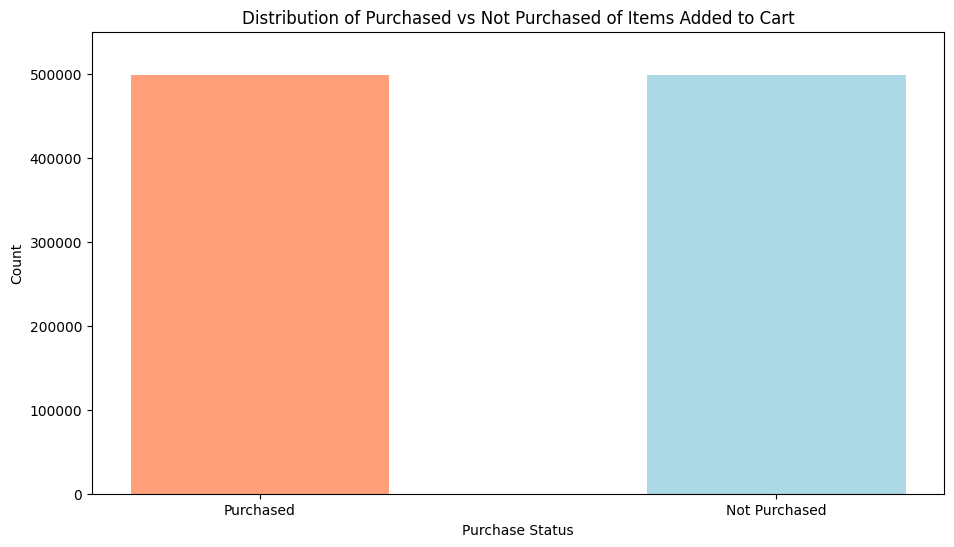

In [ ]:
purchase_counts = combined_data['is_purchased'].value_counts()

# Plot the bar chart
plt.figure(figsize = (11, 6), dpi = 100)
plt.bar(purchase_counts.index, purchase_counts.values, width=0.5, color=['lightblue', 'lightsalmon'])  # Reduced width and lighter orange
plt.xticks(purchase_counts.index, ['Not Purchased', 'Purchased'])
plt.xlabel('Purchase Status')
plt.ylabel('Count')
plt.ylim(0, 550000)
plt.title('Distribution of Purchased vs Not Purchased of Items Added to Cart')
plt.show()

### Model Selection and Training

In [ ]:
# Select features
features = combined_data.loc[:, ['brand', 'price', 'weekday', 'category', 'sub-category', 'activity_count']].copy()

# Initialize separate LabelEncoders
brand_encoder = LabelEncoder()
weekday_encoder = LabelEncoder()
category_encoder = LabelEncoder()
subcategory_encoder = LabelEncoder()

# Encode categorical variables
features['brand'] = brand_encoder.fit_transform(features['brand'].fillna("Unknown"))
features['event_weekday'] = weekday_encoder.fit_transform(features['weekday'].fillna("Unknown"))
features['category'] = category_encoder.fit_transform(features['category'].fillna("Unknown"))
features['sub-category'] = subcategory_encoder.fit_transform(features['sub-category'].fillna("Unknown"))

# Encode the target variable
is_purchased = LabelEncoder().fit_transform(combined_data['is_purchased'])

# Verify the transformation
print("Encoded Features:")
print(features.head())


Encoded Features:
        brand   price  weekday  category  sub-category  activity_count  \
498844     21  515.67        2         7            27               2   
498845     21  161.98        2         7             1               2   
498846    291  174.76        2         7            27               2   
498847    158  258.21        2         7            27               4   
498848    291  197.43        2         7            27               4   

        event_weekday  
498844              2  
498845              2  
498846              2  
498847              2  
498848              2  


In [ ]:
print(list(features.columns))

['brand', 'price', 'weekday', 'category', 'sub-category', 'activity_count', 'event_weekday']


In [ ]:
# Function to apply sampling techniques
def apply_sampling(X, y, sampling_method="smote", random_state=42):
    if sampling_method == "smote":
        smote = SMOTE(random_state=random_state)
        X_resampled, y_resampled = smote.fit_resample(X, y)
        print("Applied SMOTE for oversampling.")
    elif sampling_method == "undersample":
        undersampler = RandomUnderSampler(random_state=random_state)
        X_resampled, y_resampled = undersampler.fit_resample(X, y)
        print("Applied Random Undersampling.")
    else:
        raise ValueError("Invalid sampling method. Choose 'smote' or 'undersample'.")

    print(f"Original class distribution:\n{pd.Series(y).value_counts()}")
    print(f"Resampled class distribution:\n{pd.Series(y_resampled).value_counts()}")
    return X_resampled, y_resampled

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    features, is_purchased, test_size=0.3, random_state=42
)

# Apply the chosen sampling technique
X_train_sampled, y_train_sampled = apply_sampling(X_train, y_train, sampling_method="smote", random_state=42)

# Print shapes to confirm resampling
print(f"Resampled Training Data Shape: X_train_sampled: {X_train_sampled.shape}, y_train_sampled: {y_train_sampled.shape}")

Applied SMOTE for oversampling.
Original class distribution:
0    349222
1    349159
Name: count, dtype: int64
Resampled class distribution:
1    349222
0    349222
Name: count, dtype: int64
Resampled Training Data Shape: X_train_sampled: (698444, 7), y_train_sampled: (698444,)


In [ ]:
X_train.shape, X_test.shape

((698381, 7), (299307, 7))

In [ ]:
def scale_data(X):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    return pd.DataFrame(X_scaled, columns=X.columns)

# Scale the features
X_train_scaled = scale_data(X_train)
X_test_scaled = scale_data(X_test)

print("Scaled X_train:")
print(X_train_scaled.head())
print("Scaled X_test:")
print(X_test_scaled.head())

Scaled X_train:
      brand     price   weekday  category  sub-category  activity_count  \
0  0.765770 -0.772187 -0.499696 -2.508313     -1.055580       -0.261267   
1  0.765770 -0.848804 -1.499422 -2.508313     -1.055580       -0.261267   
2  0.765770 -0.265228 -0.499696  0.422514      0.392424       -0.261267   
3  1.279111 -0.518073  0.999893  0.422514      0.392424       -0.261267   
4  0.765770 -0.666612  0.500030  0.422514      0.392424       -0.261267   

   event_weekday  
0      -0.499696  
1      -1.499422  
2      -0.499696  
3       0.999893  
4       0.500030  
Scaled X_test:
      brand     price   weekday  category  sub-category  activity_count  \
0  0.761459 -0.248684  1.500844   0.42122      0.394158       -0.258526   
1  0.761459 -0.558859  1.000509   0.42122      0.394158       -0.258526   
2  0.442615 -0.394305  0.500173   0.42122      0.394158       -0.258526   
3  0.761459 -0.611218 -0.000162   0.42122      0.394158       -0.258526   
4 -1.338246  2.635847 -0.5004

In [ ]:
# Initialize model accuracies dictionary
model_accuracies = {}

# Handle imbalanced data with SMOTE
def handle_imbalanced_data(X, y):
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    print(f"Original class distribution:\n{pd.Series(y).value_counts()}")
    print(f"Resampled class distribution:\n{pd.Series(y_resampled).value_counts()}")
    return X_resampled, y_resampled

# Balance the training data
X_train_balanced, y_train_balanced = handle_imbalanced_data(X_train, y_train)

# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42),
    "Decision Tree": DecisionTreeClassifier(class_weight="balanced", random_state=42),
    "Random Forest": RandomForestClassifier(class_weight="balanced", random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(
        scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]), random_state=42
    ),
    "LightGBM": LGBMClassifier(random_state=42, class_weight="balanced"),
    "CatBoost": CatBoostClassifier(
        random_state=42, auto_class_weights="Balanced", iterations=500, learning_rate=0.05, verbose=0
    ),
}

# Train and evaluate models with cross-validation
results = []
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in tqdm(models.items(), desc="Training Models"):
    print(f"\nTraining {name}...")

    # Cross-validation
    cv_scores = cross_val_score(model, X_train_balanced, y_train_balanced, scoring="accuracy", cv=skf)
    print(f"Cross-Validation Accuracy Scores for {name}: {cv_scores}")
    print(f"Average CV Accuracy for {name}: {cv_scores.mean():.4f}")

    # Train the model on the entire training set
    model.fit(X_train_balanced, y_train_balanced)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None
    mcc = matthews_corrcoef(y_test, y_pred)

    # Store the results
    results.append(
        {
            "Model": name,
            "Accuracy": round(accuracy, 4),
            "Precision": round(precision, 4),
            "Recall": round(recall, 4),
            "F1-Score": round(f1, 4),
            "ROC-AUC": round(roc_auc, 4) if roc_auc else "N/A",
            "CV Accuracy": round(cv_scores.mean(), 4),
            "MCC": round(mcc, 4),
        }
    )

    # Add to model_accuracies
    model_accuracies[name] = accuracy

    # Print classification report
    print(f"\nClassification Report for {name}:")
    print(classification_report(y_test, y_pred))

Original class distribution:
0    349222
1    349159
Name: count, dtype: int64
Resampled class distribution:
1    349222
0    349222
Name: count, dtype: int64


Training Models:   0%|          | 0/7 [00:00<?, ?it/s]


Training Logistic Regression...
Cross-Validation Accuracy Scores for Logistic Regression: [0.49777721 0.49851456 0.49992483 0.49865773 0.49998568]
Average CV Accuracy for Logistic Regression: 0.4990

Classification Report for Logistic Regression:


Training Models:  14%|█▍        | 1/7 [00:30<03:00, 30.02s/it]

              precision    recall  f1-score   support

           0       0.50      0.50      0.50    149622
           1       0.50      0.50      0.50    149685

    accuracy                           0.50    299307
   macro avg       0.50      0.50      0.50    299307
weighted avg       0.50      0.50      0.50    299307


Training Decision Tree...
Cross-Validation Accuracy Scores for Decision Tree: [0.49824252 0.49693247 0.49808503 0.49717587 0.49788815]
Average CV Accuracy for Decision Tree: 0.4977

Classification Report for Decision Tree:


Training Models:  29%|██▊       | 2/7 [01:05<02:45, 33.17s/it]

              precision    recall  f1-score   support

           0       0.50      0.54      0.52    149622
           1       0.50      0.46      0.48    149685

    accuracy                           0.50    299307
   macro avg       0.50      0.50      0.50    299307
weighted avg       0.50      0.50      0.50    299307


Training Random Forest...
Cross-Validation Accuracy Scores for Random Forest: [0.4981423  0.49784879 0.49754812 0.49663896 0.49856108]
Average CV Accuracy for Random Forest: 0.4977

Classification Report for Random Forest:


Training Models:  43%|████▎     | 3/7 [16:46<29:50, 447.54s/it]

              precision    recall  f1-score   support

           0       0.50      0.49      0.50    149622
           1       0.50      0.50      0.50    149685

    accuracy                           0.50    299307
   macro avg       0.50      0.50      0.50    299307
weighted avg       0.50      0.50      0.50    299307


Training Gradient Boosting...
Cross-Validation Accuracy Scores for Gradient Boosting: [0.49782732 0.49517858 0.49785595 0.49549356 0.49523939]
Average CV Accuracy for Gradient Boosting: 0.4963

Classification Report for Gradient Boosting:


Training Models:  57%|█████▋    | 4/7 [23:02<20:58, 419.36s/it]

              precision    recall  f1-score   support

           0       0.50      0.56      0.52    149622
           1       0.49      0.43      0.46    149685

    accuracy                           0.50    299307
   macro avg       0.50      0.50      0.49    299307
weighted avg       0.50      0.50      0.49    299307


Training XGBoost...
Cross-Validation Accuracy Scores for XGBoost: [0.49553651 0.49522153 0.49619512 0.49790606 0.49600538]
Average CV Accuracy for XGBoost: 0.4962

Classification Report for XGBoost:


Training Models:  71%|███████▏  | 5/7 [23:44<09:26, 283.26s/it]

              precision    recall  f1-score   support

           0       0.50      0.49      0.49    149622
           1       0.50      0.50      0.50    149685

    accuracy                           0.50    299307
   macro avg       0.50      0.50      0.50    299307
weighted avg       0.50      0.50      0.50    299307


Training LightGBM...
[LightGBM] [Info] Number of positive: 279377, number of negative: 279378
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029593 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 468
[LightGBM] [Info] Number of data points in the train set: 558755, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 279377, number of negative: 279378
[LightGBM] [Info] A

Training Models:  86%|████████▌ | 6/7 [24:16<03:17, 197.87s/it]

              precision    recall  f1-score   support

           0       0.50      0.56      0.53    149622
           1       0.50      0.43      0.46    149685

    accuracy                           0.50    299307
   macro avg       0.50      0.50      0.50    299307
weighted avg       0.50      0.50      0.50    299307


Training CatBoost...
Cross-Validation Accuracy Scores for CatBoost: [0.49743358 0.4974837  0.49933066 0.49755528 0.49770202]
Average CV Accuracy for CatBoost: 0.4979

Classification Report for CatBoost:


Training Models: 100%|██████████| 7/7 [31:14<00:00, 267.72s/it]

              precision    recall  f1-score   support

           0       0.50      0.51      0.50    149622
           1       0.50      0.48      0.49    149685

    accuracy                           0.50    299307
   macro avg       0.50      0.50      0.50    299307
weighted avg       0.50      0.50      0.50    299307



Results DataFrame:
                 Model  Accuracy  Precision  Recall  F1-Score  ROC-AUC  \
0  Logistic Regression    0.4986     0.4987  0.5010    0.4999   0.4981   
1        Decision Tree    0.4985     0.4985  0.4578    0.4773   0.4985   
2        Random Forest    0.4993     0.4994  0.5038    0.5016   0.4988   
3    Gradient Boosting    0.4954     0.4949  0.4334    0.4621   0.4925   
4              XGBoost    0.4952     0.4953  0.4994    0.4973   0.4926   
5             LightGBM    0.4976     0.4973  0.4348    0.4640   0.4967   
6             CatBoost    0.4972     0.4972  0.4837    0.4904   0.4967   
7        Deep Learning    0.5001        NaN     NaN       NaN      NaN   

   CV Accuracy     MCC  
0       0.4990 -0.0028  
1       0.4977 -0.0029  
2       0.4977 -0.0014  
3       0.4963 -0.0093  
4       0.4962 -0.0097  
5       0.4981 -0.0049  
6       0.4979 -0.0056  
7          NaN     NaN  
Cleaned Results DataFrame:
                 Model  Accuracy  Precision  Recall  F1-Score 

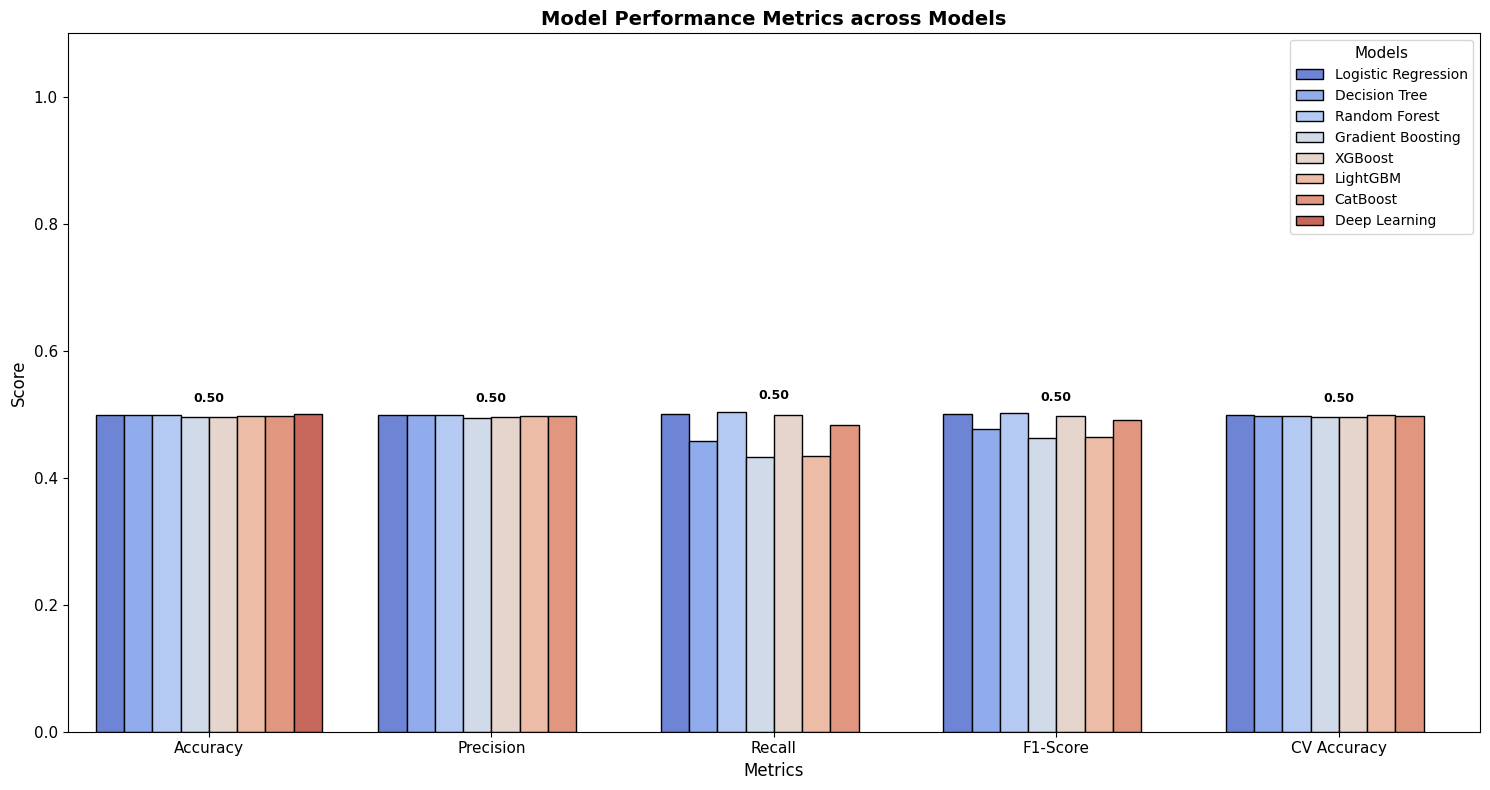

In [ ]:
# If `results_df` is not already defined, create it from `results`
if 'results_df' not in locals():
    results_df = pd.DataFrame(results)

# Verify the structure of `results_df`
print("Results DataFrame:")
print(results_df)

# Replace "N/A" with np.nan and convert columns to numeric where possible
numeric_columns = ["Accuracy", "Precision", "Recall", "F1-Score", "ROC-AUC", "CV Accuracy", "MCC"]
for col in numeric_columns:
    results_df[col] = pd.to_numeric(results_df[col], errors="coerce")

# Verify the structure of `results_df` after cleaning
print("Cleaned Results DataFrame:")
print(results_df)

# Visualization code
plt.figure(figsize=(15, 8), dpi=100)

# Melt the DataFrame for easier plotting
results_df_melted = results_df.melt(
    id_vars=["Model"],
    value_vars=["Accuracy", "Precision", "Recall", "F1-Score", "CV Accuracy"],
    var_name="Metric",
    value_name="Score"
)

# Highlight the best score for each metric
best_scores = results_df_melted.groupby("Metric")["Score"].transform(max) == results_df_melted["Score"]
results_df_melted["Best"] = best_scores

# Create a bar plot
sns.barplot(
    x="Metric",
    y="Score",
    hue="Model",
    data=results_df_melted,
    palette="coolwarm",
    dodge=True,
    edgecolor="black"
)

# Add annotations for the best scores
for index, row in results_df_melted[results_df_melted["Best"]].iterrows():
    plt.text(
        x=row["Metric"],
        y=row["Score"] + 0.02,
        s=f"{row['Score']:.2f}",
        ha="center",
        fontsize=9,
        weight="bold",
        color="black"
    )

# Customize plot aesthetics
plt.title("Model Performance Metrics across Models", fontsize=14, weight="bold")
plt.ylabel("Score", fontsize=12)
plt.xlabel("Metrics", fontsize=12)
plt.xticks(fontsize=11, rotation=0)
plt.yticks(fontsize=11)
plt.legend(title="Models", loc="upper right", fontsize=10, title_fontsize=11)
plt.ylim(0, 1.1)
plt.tight_layout()

# Display the plot
plt.show()

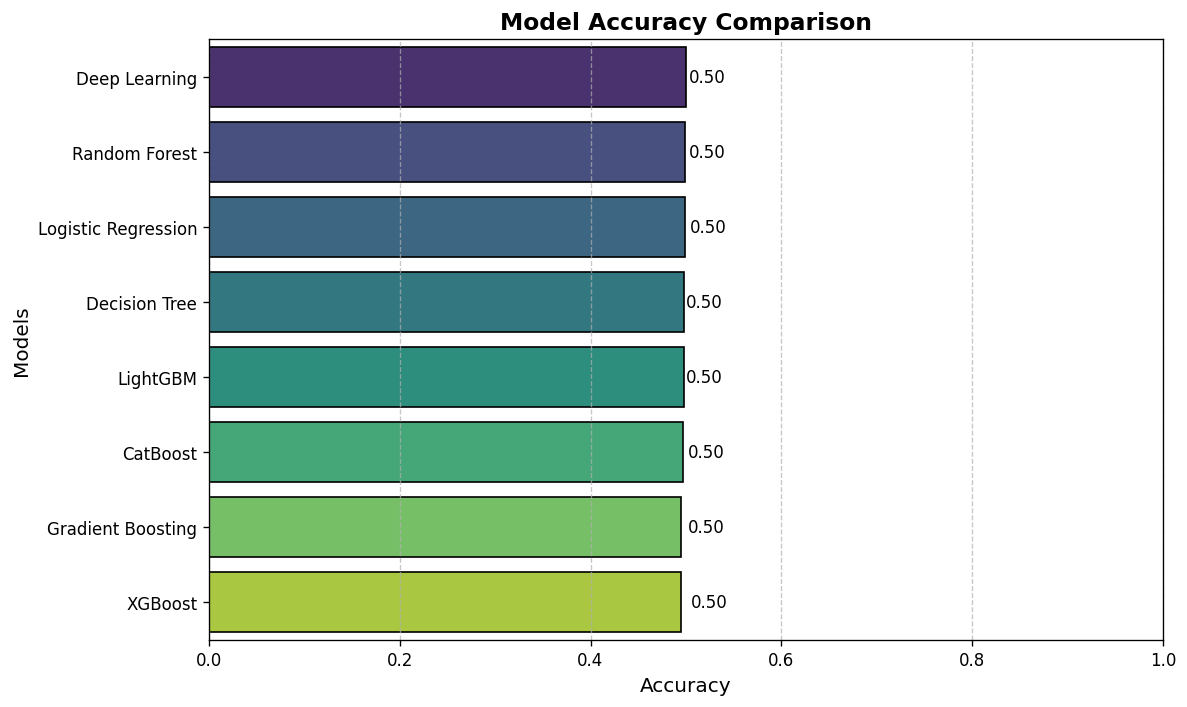

In [ ]:
# Plot Accuracy Only
plt.figure(figsize=(10, 6), dpi=120)

# Extract only accuracy values for plotting
accuracy_data = results_df[["Model", "Accuracy"]].copy()

# Sort by accuracy for better visualization
accuracy_data = accuracy_data.sort_values(by="Accuracy", ascending=False)

# Plot
sns.barplot(
    x="Accuracy",
    y="Model",
    data=accuracy_data,
    palette="viridis",
    edgecolor="black"
)

# Add annotations
for index, row in accuracy_data.iterrows():
    plt.text(
        row["Accuracy"] + 0.005,  # Position text slightly to the right
        index,  # y-coordinate
        f"{row['Accuracy']:.2f}",  # Display accuracy value
        color="black",
        va="center",
        fontsize=10
    )

# Customize plot aesthetics
plt.title("Model Accuracy Comparison", fontsize=14, weight="bold")
plt.xlabel("Accuracy", fontsize=12)
plt.ylabel("Models", fontsize=12)
plt.xlim(0, 1)  # Accuracy values between 0 and 1
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis="x", linestyle="--", alpha=0.7)  # Add gridlines for clarity
plt.tight_layout()

# Display the plot
plt.show()

In [ ]:
print("Original Class Distribution:", pd.Series(y_train).value_counts())
print("Balanced Class Distribution:", pd.Series(y_train_balanced).value_counts())

Original Class Distribution: 0    349222
1    349159
Name: count, dtype: int64
Balanced Class Distribution: 1    349222
0    349222
Name: count, dtype: int64


### Model Evaluation

In [ ]:
# Normalize the data for Deep Learning
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build the Deep Learning Model
def create_deep_learning_model(input_dim):
    model = Sequential()
    model.add(Dense(128, activation='relu', input_dim=input_dim))
    model.add(Dropout(0.4))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy', 'Precision', 'Recall', 'AUC'])
    return model

# Callbacks for Early Stopping and Learning Rate Reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# Train the Deep Learning Model
dl_model = create_deep_learning_model(X_train_scaled.shape[1])
history = dl_model.fit(
    X_train_scaled,
    y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping, lr_scheduler],
    verbose=1
)

# Evaluate the Deep Learning Model
y_pred_dl = (dl_model.predict(X_test_scaled) > 0.5).astype(int)
accuracy_dl = accuracy_score(y_test, y_pred_dl)

# Update model_accuracies with Deep Learning Model
model_accuracies["Deep Learning"] = accuracy_dl

# Print classification report for Deep Learning
print("Classification Report for Deep Learning Model:")
print(classification_report(y_test, y_pred_dl))
print(f"Deep Learning Model Accuracy: {accuracy_dl:.4f}")

# Summarize results
results_df = pd.DataFrame(results)

# Create a new DataFrame for Deep Learning metrics
dl_results = pd.DataFrame([{
    "Model": "Deep Learning",
    "Accuracy": round(accuracy_dl, 4),
    "Precision": "N/A",
    "Recall": "N/A",
    "F1-Score": "N/A",
    "ROC-AUC": "N/A",
    "CV Accuracy": "N/A",
    "MCC": "N/A",
}])

# Use pd.concat to append the new metrics
results_df = pd.concat([results_df, dl_results], ignore_index=True)

# Final Results
print("\nSummary of Model Performance:")
print(results_df)

Epoch 1/50
17460/17460 ━━━━━━━━━━━━━━━━━━━━ 55s 3ms/step - AUC: 0.5002 - Precision: 0.5007 - Recall: 0.5395 - accuracy: 0.5005 - loss: 0.6942 - val_AUC: 0.5000 - val_Precision: 0.4991 - val_Recall: 1.0000 - val_accuracy: 0.4991 - val_loss: 0.6932 - learning_rate: 0.0010
Epoch 2/50
17460/17460 ━━━━━━━━━━━━━━━━━━━━ 82s 3ms/step - AUC: 0.4992 - Precision: 0.5009 - Recall: 0.5486 - accuracy: 0.5004 - loss: 0.6932 - val_AUC: 0.5000 - val_Precision: 0.4781 - val_Recall: 0.0162 - val_accuracy: 0.5001 - val_loss: 0.6931 - learning_rate: 0.0010
Epoch 3/50
17460/17460 ━━━━━━━━━━━━━━━━━━━━ 84s 3ms/step - AUC: 0.5002 - Precision: 0.5005 - Recall: 0.5890 - accuracy: 0.5001 - loss: 0.6932 - val_AUC: 0.5000 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5009 - val_loss: 0.6931 - learning_rate: 0.0010
Epoch 4/50
17460/17460 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.4993 - Precision: 0.5001 - Recall: 0.5067 - accuracy: 0.5012 - loss: 0.6932
Epoch 4: ReduceLROnPlateau reducing le

In [ ]:
print("Model Accuracies:", model_accuracies)

Model Accuracies: {'Logistic Regression': 0.4985850648330978, 'Decision Tree': 0.4985416311679981, 'Random Forest': 0.4992967087305008, 'Gradient Boosting': 0.49538767887152657, 'XGBoost': 0.49516382844370493, 'LightGBM': 0.4975727263311583, 'CatBoost': 0.49720855175455303, 'Deep Learning': 0.5001052431115878}


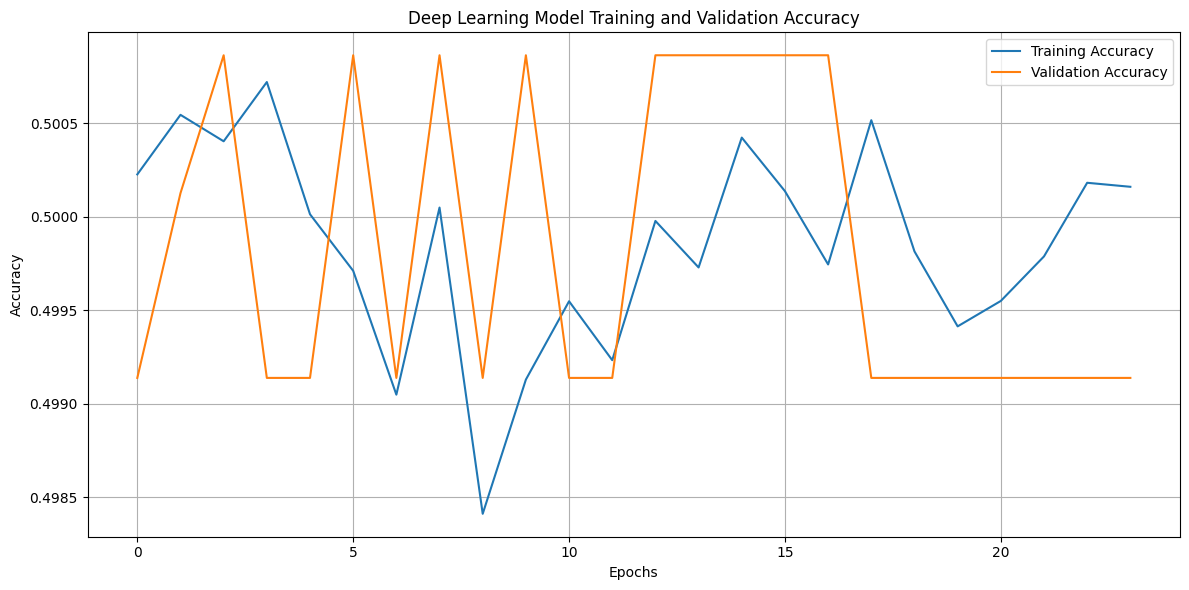

In [ ]:
# Plot training and validation metrics
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Deep Learning Model Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

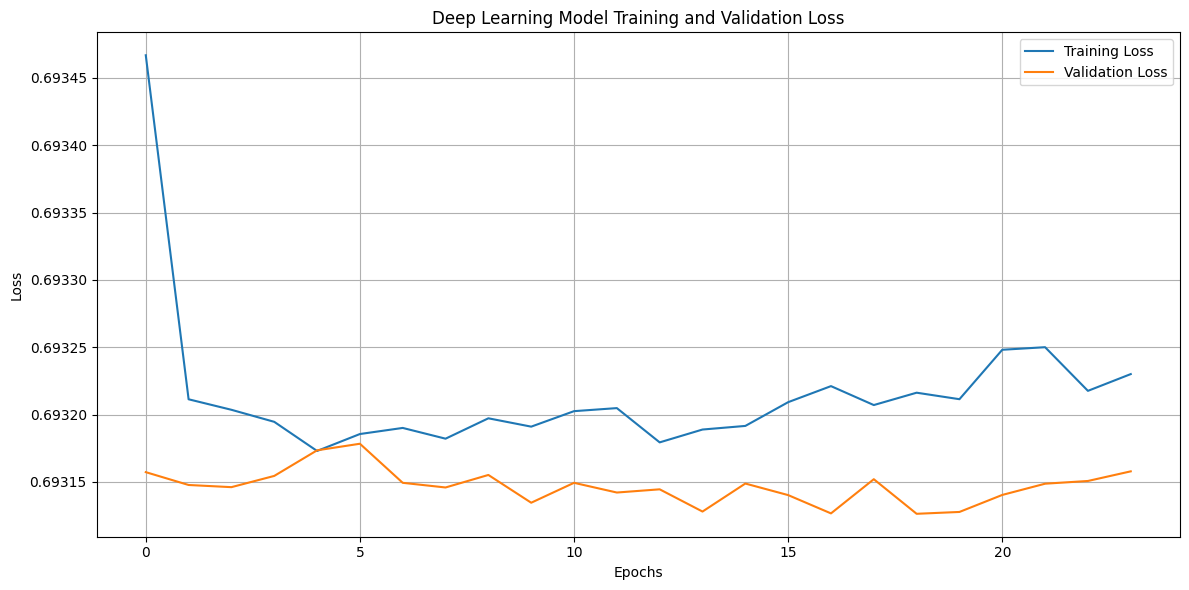

In [ ]:
# Plot Training and Validation Loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Deep Learning Model Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

Metrics for Logistic Regression:
Accuracy: 0.50
Precision: 0.50
Recall: 0.50
F1-Score: 0.50
ROC-AUC: 0.49813534518472896
------------------------------------------------------------
Metrics for Decision Tree:
Accuracy: 0.50
Precision: 0.50
Recall: 0.46
F1-Score: 0.48
ROC-AUC: 0.4985292324818121
------------------------------------------------------------
Metrics for Random Forest:
Accuracy: 0.50
Precision: 0.50
Recall: 0.50
F1-Score: 0.50
ROC-AUC: 0.498845448303271
------------------------------------------------------------
Metrics for Gradient Boosting:
Accuracy: 0.50
Precision: 0.49
Recall: 0.43
F1-Score: 0.46
ROC-AUC: 0.49246963208426964
------------------------------------------------------------
Metrics for XGBoost:
Accuracy: 0.50
Precision: 0.50
Recall: 0.50
F1-Score: 0.50
ROC-AUC: 0.4925785947373186
------------------------------------------------------------
Metrics for LightGBM:
Accuracy: 0.50
Precision: 0.50
Recall: 0.43
F1-Score: 0.46
ROC-AUC: 0.4966741681237004
-----------

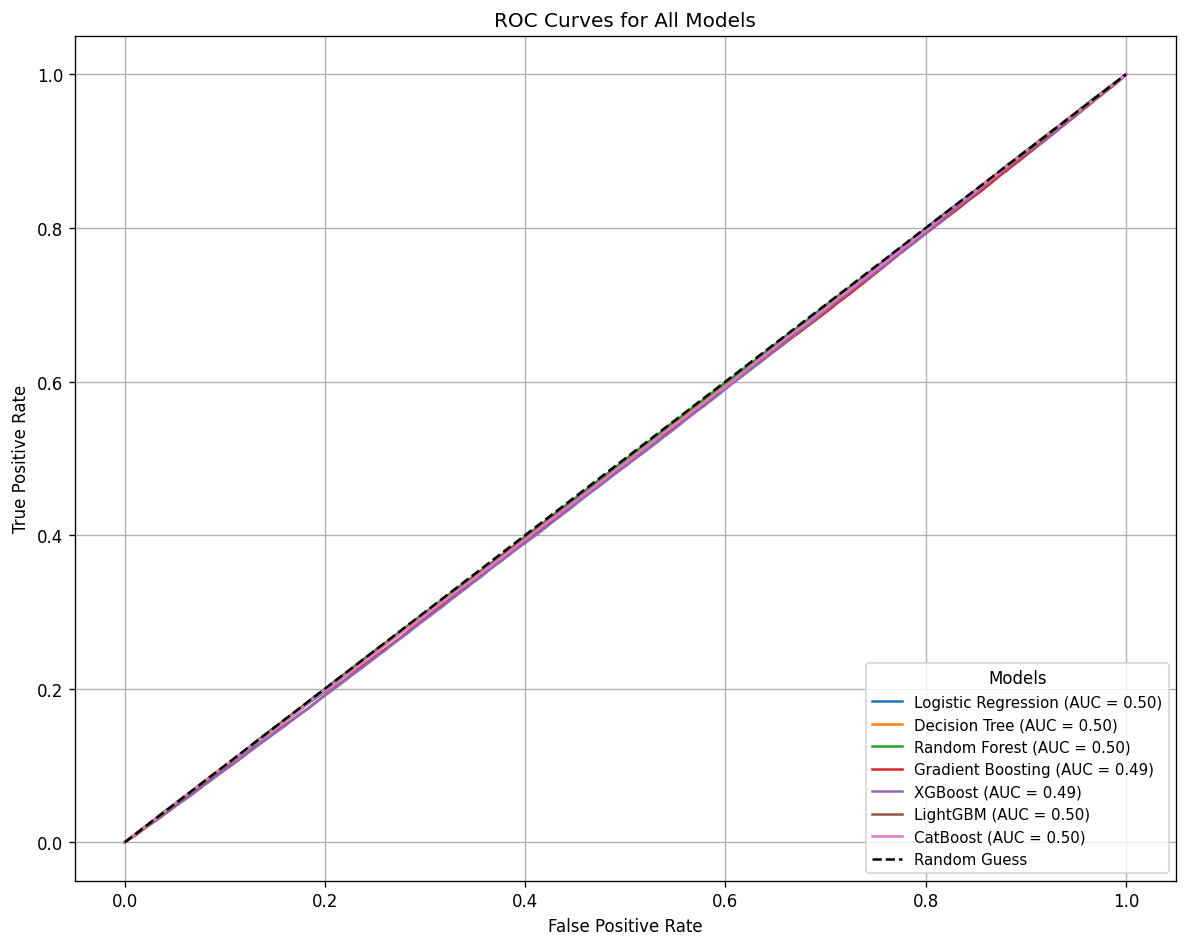

In [ ]:
# Enhanced evaluation metrics
model_metrics = {}
plt.figure(figsize=(10, 8), dpi=120)  # Initialize a single plot

for name, model in models.items():
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    # Metrics Calculation
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None

    # Store metrics
    model_metrics[name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "ROC-AUC": roc_auc
    }

    # Print metrics
    print(f"Metrics for {name}:")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1-Score: {f1:.2f}")
    print(f"ROC-AUC: {roc_auc}")
    print("-" * 60)

    # Add ROC Curve to the plot
    if y_pred_proba is not None:
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

# Customize the single ROC Curve plot
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')  # Dashed diagonal line
plt.title("ROC Curves for All Models")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(title="Models", loc="lower right", fontsize=9)
plt.grid(True)
plt.tight_layout()
plt.show()

Logistic Regression Brier Score: 0.2500
Decision Tree Brier Score: 0.2955
Random Forest Brier Score: 0.2788
Gradient Boosting Brier Score: 0.2501
XGBoost Brier Score: 0.2507
LightGBM Brier Score: 0.2501
CatBoost Brier Score: 0.2501


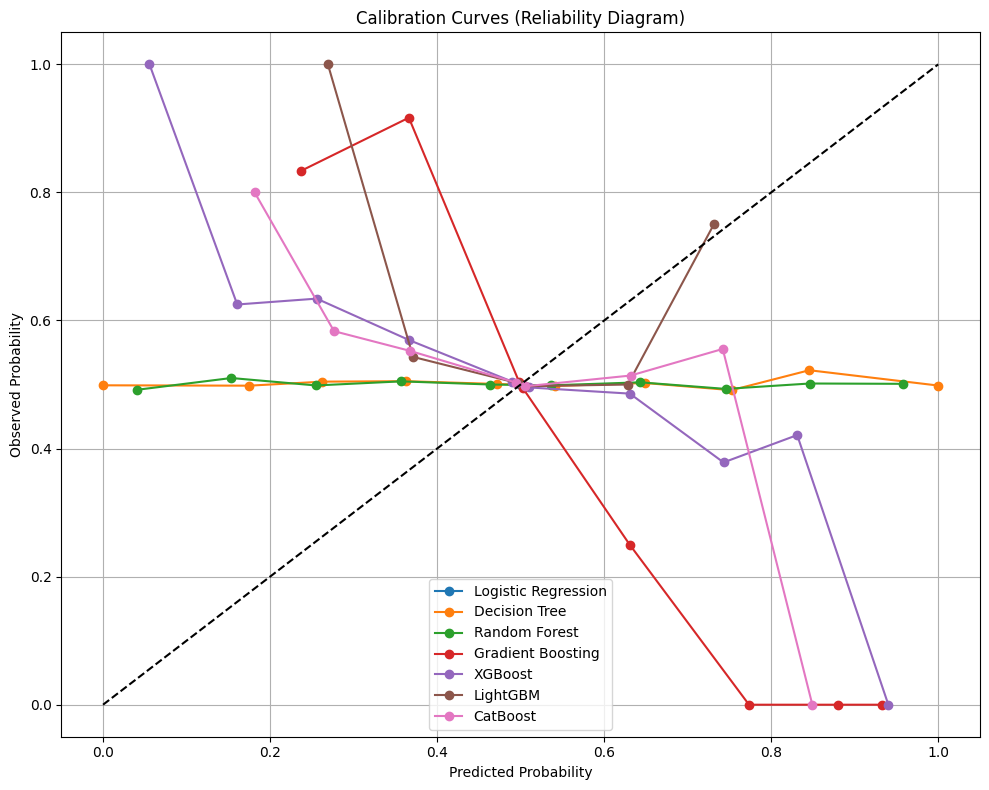

In [ ]:
def evaluate_calibration(models, X_test, y_test):
    plt.figure(figsize=(10, 8))
    plt.title("Calibration Curves (Reliability Diagram)")

    for name, model in models.items():
        if hasattr(model, "predict_proba"):
            y_pred_proba = model.predict_proba(X_test)[:, 1]
            prob_true, prob_pred = calibration_curve(y_test, y_pred_proba, n_bins=10, strategy='uniform')

            # Plot calibration curve
            plt.plot(prob_pred, prob_true, marker='o', label=f"{name}")

            # Calculate and print Brier score
            brier_score = brier_score_loss(y_test, y_pred_proba)
            print(f"{name} Brier Score: {brier_score:.4f}")

    plt.plot([0, 1], [0, 1], 'k--')  # Perfectly calibrated line
    plt.xlabel("Predicted Probability")
    plt.ylabel("Observed Probability")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Evaluate calibration
evaluate_calibration(models, X_test, y_test)

In [ ]:
def chi_square_test(df, feature, target):
    try:
        contingency_table = pd.crosstab(df[feature], df[target])
        chi2, p, dof, expected = chi2_contingency(contingency_table)

        print(f"Chi-Square Test for {feature} vs {target}:")
        print(f"Chi-Square Statistic: {chi2:.4f}")
        print(f"Degrees of Freedom: {dof}")
        print(f"P-Value: {p:.4f}")

        if p < 0.05:
            print(f"Result: Significant association between {feature} and {target}.")
        else:
            print(f"Result: No significant association between {feature} and {target}.")
        print("-" * 60)
    except Exception as e:
        print(f"Error performing Chi-Square test for {feature} vs {target}: {e}")

In [ ]:
# Perform Chi-Square Test for categorical features
categorical_features = ['category', 'subcategory', 'event_weekday', 'is_weekend']
target = 'is_purchased'

for feature in categorical_features:
    chi_square_test(df_targets, feature, target)


def perform_t_test(df, numeric_feature, target):
    try:
        group1 = df[df[target] == 0][numeric_feature].dropna()
        group2 = df[df[target] == 1][numeric_feature].dropna()
        stat, p = ttest_ind(group1, group2, equal_var=False)
        print(f"T-Test for {numeric_feature} by {target}:")
        print(f"T-Statistic: {stat:.4f}, P-Value: {p:.4f}")
        if p < 0.05:
            print(f"Result: Significant difference in {numeric_feature} between groups.")
        else:
            print(f"Result: No significant difference in {numeric_feature} between groups.")
        print("-" * 60)
    except Exception as e:
        print(f"Error performing T-Test for {numeric_feature} by {target}: {e}")


def perform_anova_test(df, numeric_feature, categorical_feature):
    try:
        groups = [df[df[categorical_feature] == category][numeric_feature].dropna() for category in df[categorical_feature].unique()]
        stat, p = f_oneway(*groups)
        print(f"ANOVA Test for {numeric_feature} by {categorical_feature}:")
        print(f"F-Statistic: {stat:.4f}, P-Value: {p:.4f}")
        if p < 0.05:
            print(f"Result: Significant difference in {numeric_feature} across {categorical_feature}.")
        else:
            print(f"Result: No significant difference in {numeric_feature} across {categorical_feature}.")
        print("-" * 60)
    except Exception as e:
        print(f"Error performing ANOVA for {numeric_feature} by {categorical_feature}: {e}")

Chi-Square Test for category vs is_purchased:
Chi-Square Statistic: 0.0000
Degrees of Freedom: 12
P-Value: 1.0000
Result: No significant association between category and is_purchased.
------------------------------------------------------------
Chi-Square Test for subcategory vs is_purchased:
Chi-Square Statistic: 0.0000
Degrees of Freedom: 37
P-Value: 1.0000
Result: No significant association between subcategory and is_purchased.
------------------------------------------------------------
Error performing Chi-Square test for event_weekday vs is_purchased: 'event_weekday'
Chi-Square Test for is_weekend vs is_purchased:
Chi-Square Statistic: 0.0000
Degrees of Freedom: 1
P-Value: 1.0000
Result: No significant association between is_weekend and is_purchased.
------------------------------------------------------------


In [ ]:
# Perform hypothesis tests
numeric_features = ['price', 'activity_count']
target = 'is_purchased'

for feature in numeric_features:
    perform_t_test(df_targets, feature, target)

categorical_feature = 'category'
for feature in numeric_features:
    perform_anova_test(df_targets, feature, categorical_feature)

T-Test for price by is_purchased:
T-Statistic: 0.0000, P-Value: 1.0000
Result: No significant difference in price between groups.
------------------------------------------------------------
T-Test for activity_count by is_purchased:
T-Statistic: 0.0000, P-Value: 1.0000
Result: No significant difference in activity_count between groups.
------------------------------------------------------------
ANOVA Test for price by category:
F-Statistic: 3765.4552, P-Value: 0.0000
Result: Significant difference in price across category.
------------------------------------------------------------
ANOVA Test for activity_count by category:
F-Statistic: 40.9236, P-Value: 0.0000
Result: Significant difference in activity_count across category.
------------------------------------------------------------


### Results and Insights

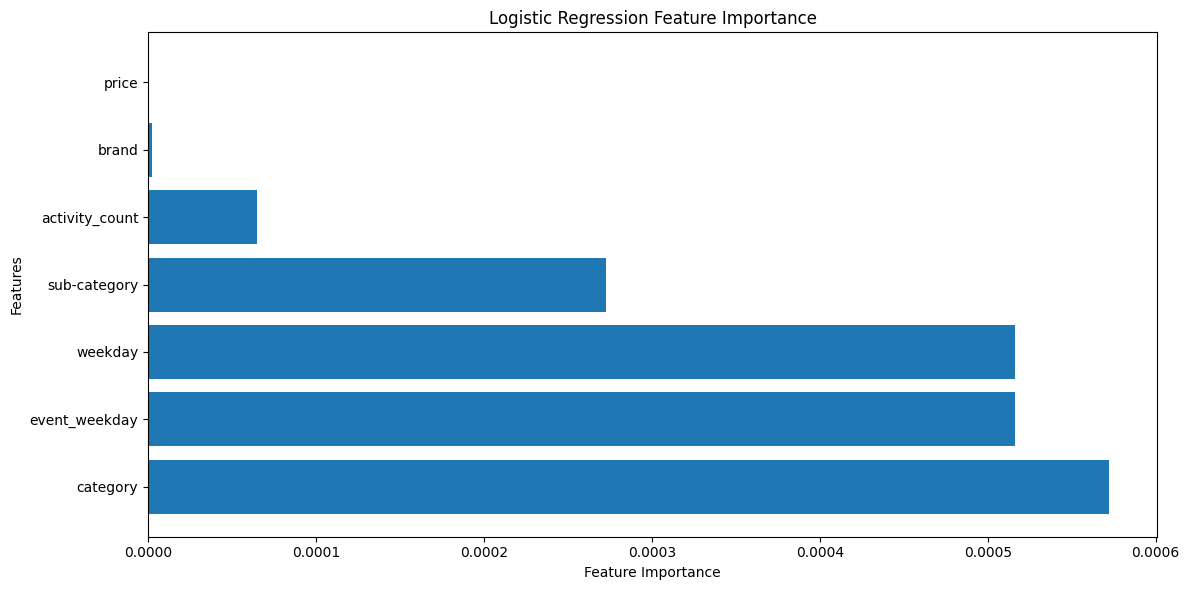

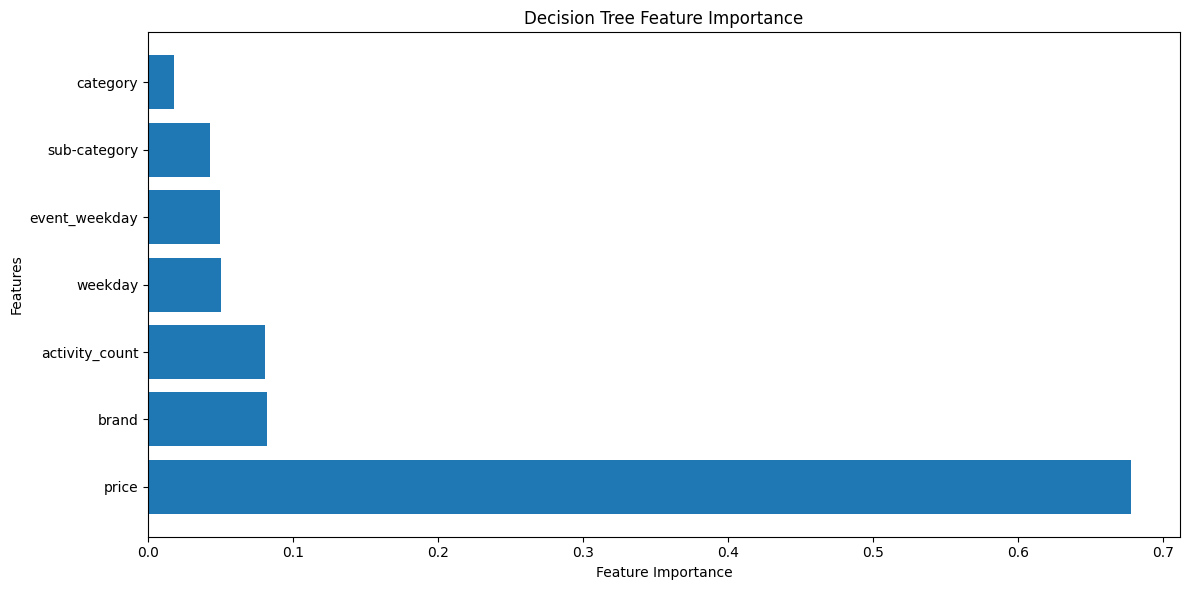

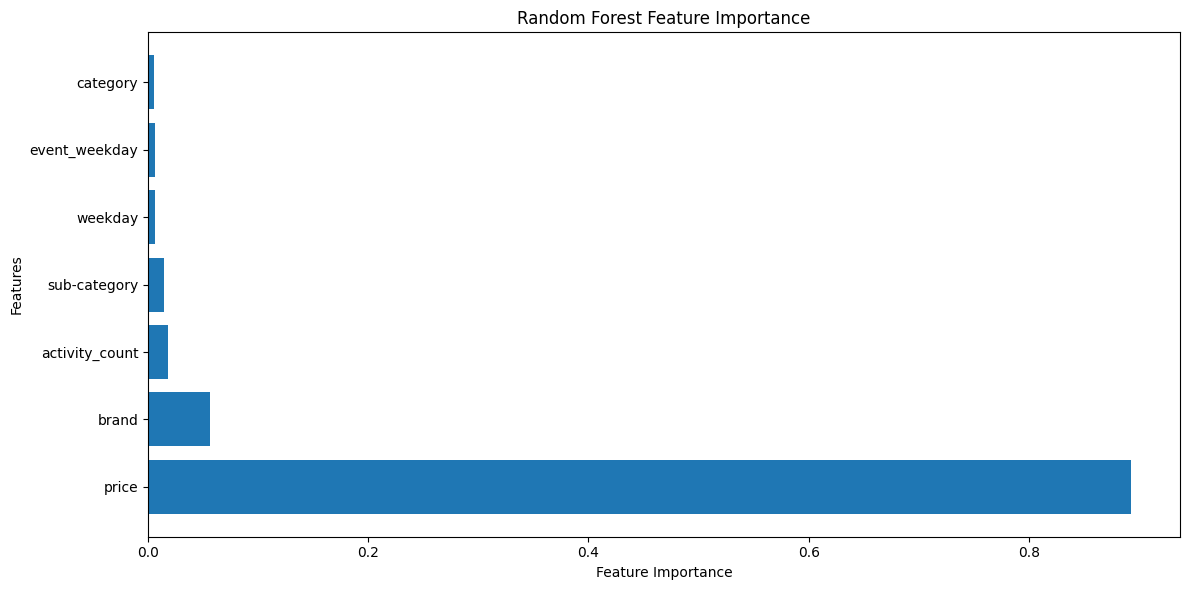

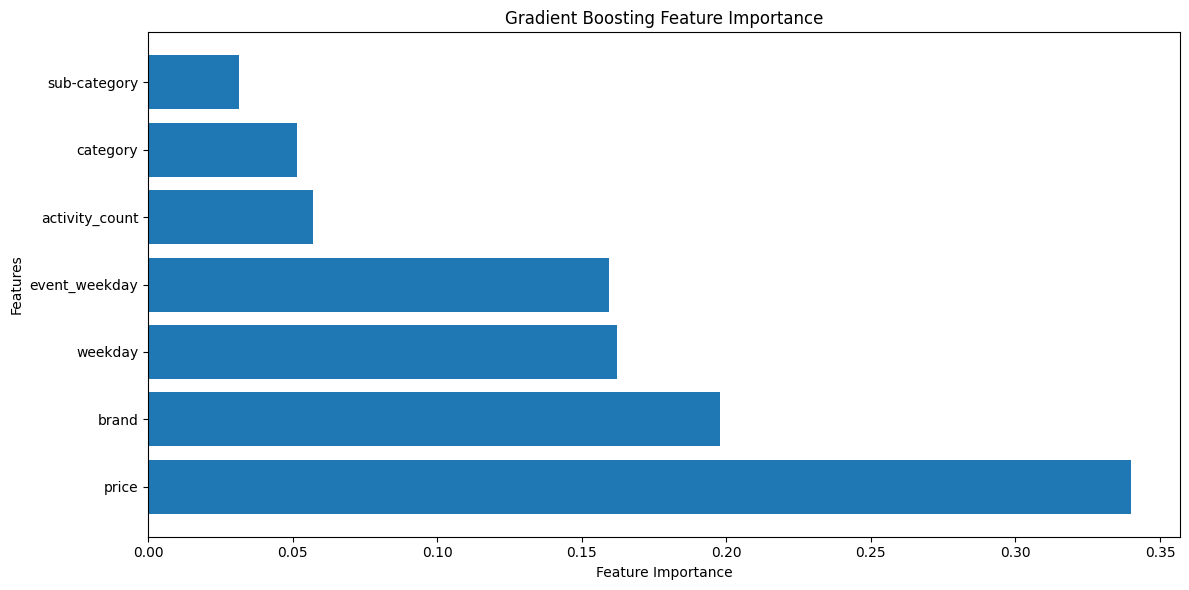

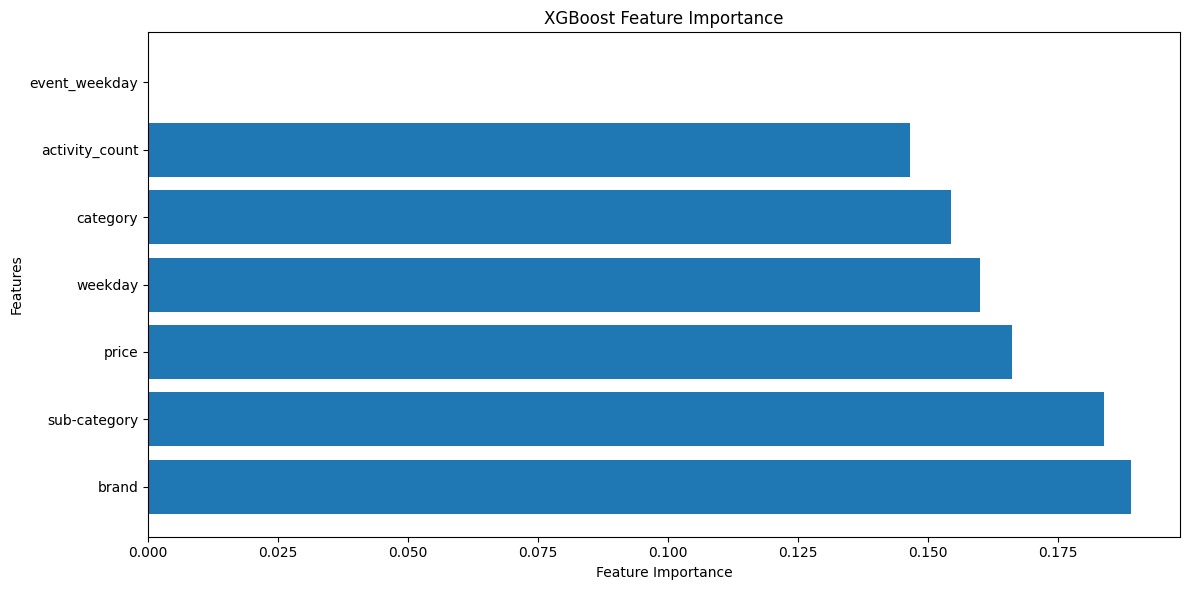

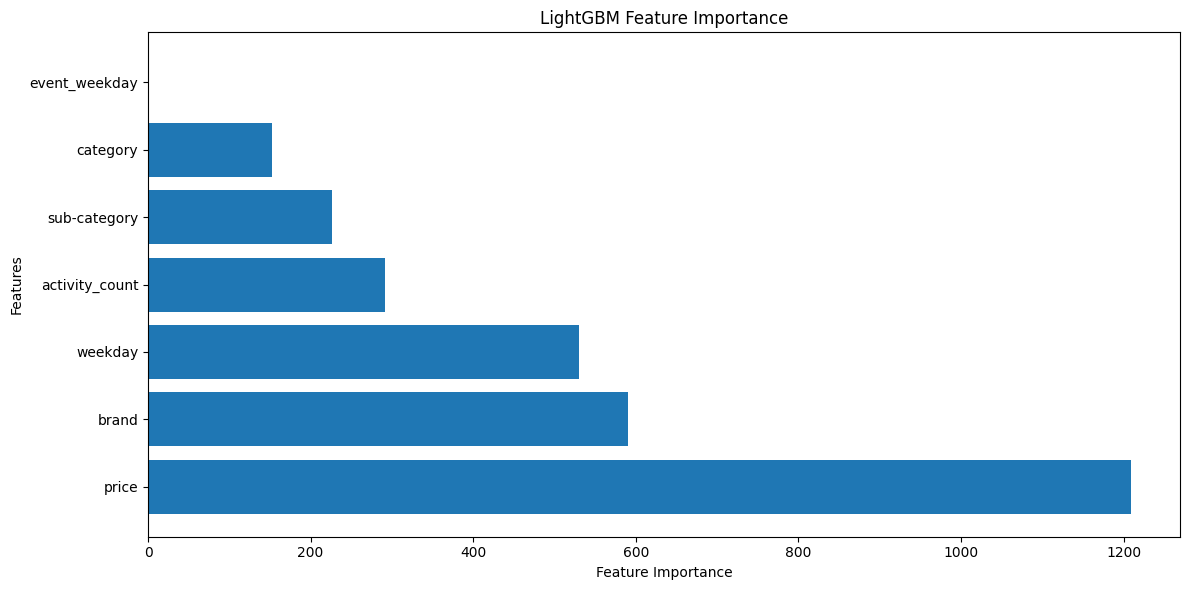

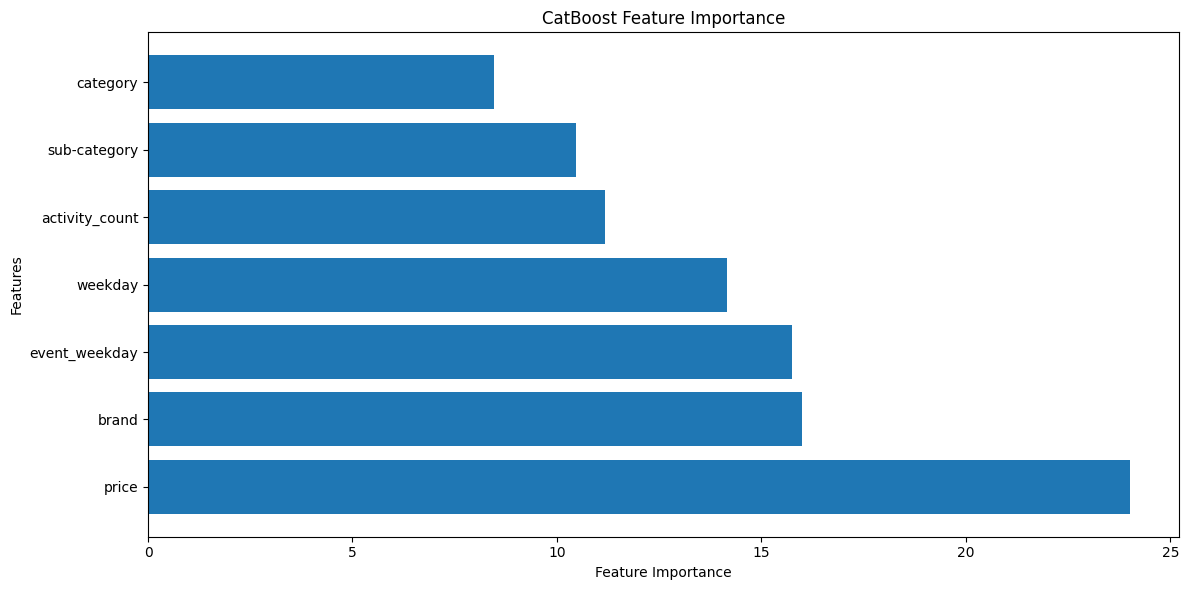

In [ ]:
feature_cols = X_train.columns

# Plot feature importance for each model
for name, model in models.items():
    plt.figure(figsize=(12, 6), dpi=100)
    plt.title(f"{name} Feature Importance")

    try:
        if hasattr(model, "coef_"):  # For models like Logistic Regression
            feature_importance = np.abs(model.coef_[0])
        elif hasattr(model, "feature_importances_"):  # For tree-based models
            feature_importance = model.feature_importances_
        else:
            print(f"Feature importance not available for {name}. Skipping...")
            continue

        # Sort the features by importance in descending order
        indices = np.argsort(feature_importance)[::-1]

        # Plot feature importance
        plt.barh(np.array(feature_cols)[indices], feature_importance[indices])
        plt.xlabel('Feature Importance')
        plt.ylabel('Features')
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error processing feature importance for {name}: {e}")
